# 3D Image Classification from Jacobian Maps Derived from MRI Scans

**Author:** [Andjela Dimitrijevic](https://twitter.com/AndjelaaaaDimi)<br>
**Date created:** 2023/09/23<br>
**Last modified:** 2023/10/24<br>
**Description:** Train a 3D convolutional neural network to predict if Jacobian maps are from intra or inter-subject pairs of MRI scans

## Source
This code has been adapted from this very well explained [github project](https://github.com/hasibzunair/3D-image-classification-tutorial) by Hasib Zunair where more resources can be found concerning the use of 3D CNNs in medical imaging.

## Setup

In [159]:
# tf2 environment
import os
import random 
import glob
import zipfile
import numpy as np
import nibabel as nib
from scipy import ndimage
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import re
from tensorflow import keras
from tensorflow.keras import layers

## Loading data and preprocessing

The files are provided in Nifti format with the extension .nii. To read the
scans, we use the `nibabel` package.
You can install the package via `pip install nibabel`. Log Jacobians are obtained using ANTs SyN method for both inter and intra pairs. These have values between -1 and 1 because of the log operation. Values smaller than 0 indicate expanding, larger than 0, contracting regions and no volume change is represented by a voxel value of 0.

To process the data, we do the following:

* We first rotate the volumes by 90 degrees, so the orientation is fixed
* We keep the values between -1 and 1.
* We resize width, height and depth.

Here we define several helper functions to process the data. These functions
will be used when building training and validation datasets.

In [160]:
def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


def normalize(volume):
    """Normalize the volume"""
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # No normalization want to keep values from -1 to 1, only converts to float32
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume


Let's read the paths of the MRI scans from the class directories.

In [161]:
# Folder "intra" consists of MRI scans from intra-registration and "inter" from inter-registration pairs.
def read_paths(path_intra, path_inter, experiment_name_intra, experiment_name_inter):
    """
    Retrieve file paths for MRI scans based on the specified experiment_name.

    Parameters:
    - path_intra (str): path to folders of pairs containing the intra logJacobian volumes 
    - path_inter (str): path to folders of pairs containing the inter logJacobian volumes 
    - experiment_name_intra (str): The name of the experiment, determining the specific set of MRI scans to be processed. 
                            Possible values include inter_mix_ra, inter_mix_r, intra_mix_r, intra_mix_ra, 
                            and all combinations from inter_f_ra and inter_m_r.
    - experiment_name_inter (str): Here, 'inter' and 'intra' represent the types of pairs, 'mix' indicates the presence 
                            of both males (m) and females (f), 'r' implies rigid registration, and 'ra' indicates both rigid 
                            and affine registration before.

    Returns:
    - intra_scan_paths (list): A list of file paths for MRI scans with the specified experiment_name and "intra" type.
    - nbr_intra_pairs (int): The number of pairs of MRI scans for the "intra" type.
    - inter_scan_paths (list): A list of file paths for MRI scans with the specified experiment_name and "inter" type.
    - nbr_inter_pairs (int): The number of pairs of MRI scans for the "inter" type.
    """
    
    intra_scan_paths = glob.glob(f"{path_intra}/{experiment_name_intra}/**/logJacobian.nii.gz", recursive=True)

    inter_scan_paths = glob.glob(f"{path_inter}/{experiment_name_inter}/**/logJacobian.nii.gz", recursive=True)
    print(inter_scan_paths[0])
    print("Nbr of MRI scans with intra log Jacobian: " + str(len(intra_scan_paths)))
    print("Nbr of MRI scans with inter log Jacobian: " + str(len(inter_scan_paths)))

    nbr_intra_pairs = len(intra_scan_paths)
    nbr_inter_pairs = len(inter_scan_paths)

    return intra_scan_paths, nbr_intra_pairs, inter_scan_paths, nbr_inter_pairs


In [162]:
def read_tsv_and_create_dict(file_path):
    """
    Reads a TSV (Tab-Separated Values) file containing participant information and creates a dictionary
    mapping participant IDs to their unique identifiers, associated scan IDs, sex, and age.

    Parameters:
    - file_path (str): The path to the TSV file containing participant information.

    Returns:
    - participant_mapping (dict): A dictionary where participant IDs are keys, and the corresponding values
                                  are dictionaries containing 'id' (unique identifier), 'scan_ids' (list of scan IDs),
                                  'sex' (list of participant sexes), and 'age' (list of participant ages).

    Example Usage:
    participant_info = read_tsv_and_create_dict("/path/to/all-participants.tsv")
    # Access information for a participant with ID '10006'
    p001_info = participant_info.get('10006', {})
    print(f"Participant P001 has unique ID: {p001_info.get('id')}, Scan IDs: {p001_info.get('scan_ids')}, "
          f"Sex: {p001_info.get('sex')}, Age: {p001_info.get('age')}")
    """
    participant_mapping = {}
    
    with open(file_path, 'r') as file:
        header = file.readline()  # Skip the header line
        for line in file:
            participant_id, sub_id_bids, scan_id, session, age, sex, group = line.strip().split('\t')
            
            # Convert age to float
            age = float(age)
            
            # Check if the participant_id is already in the mapping, if not, assign it a unique identifier
            if participant_id not in participant_mapping:
                unique_id = len(participant_mapping)
                participant_mapping[participant_id] = {'id': unique_id, 'scan_ids': [], 'sex':[], 'age':[]}
            
            # Append the scan_id to the participant's list
            participant_mapping[participant_id]['scan_ids'].append(scan_id)
            # Add the sex information if it hasn't been added yet
            if len(participant_mapping[participant_id]['sex']) == 0:
                participant_mapping[participant_id]['sex'].append(sex)
            # Append the age
            if len(participant_mapping[participant_id]['age']) == 0:
                participant_mapping[participant_id]['age'].append(age)
    
    return participant_mapping

In [163]:
def read_tsv_and_create_dataframe(file_path):
    """
    Reads a TSV (Tab-Separated Values) file containing participant information and creates a pandas DataFrame
    with columns for participant ID, scan ID, age, and sex.

    Parameters:
    - file_path (str): The path to the TSV file containing participant information.

    Returns:
    - df (pandas.DataFrame): A DataFrame containing participant data with columns 'participant_id', 'scan_id',
                             'age', and 'sex'.

    Example Usage:
    participant_df = read_tsv_and_create_dataframe("/path/to/participant_info.tsv")
    # Access the DataFrame columns and rows as needed
    print(participant_df.head())
    """
    participant_data = []
    
    with open(file_path, 'r') as file:
        header = file.readline()  # Skip the header line
        for line in file:
            participant_id, sub_id_bids, scan_id, session, age, sex, group = line.strip().split('\t')
            
            # Convert age to float
            age = float(age)
            
            # Append data to participant_data list
            participant_data.append([participant_id, scan_id, age, sex])
            
    # Create a DataFrame with the participant data
    columns = ['participant_id', 'scan_id', 'age', 'sex']
    df = pd.DataFrame(participant_data, columns=columns)
    
    return df

In [164]:
def find_scan_ids(name):
    """
    Extracts patient numbers, moving and fixed image scan IDs from a given folder name for further analysis.

    Parameters:
    - name (str): The folder name containing information about patient numbers and scan IDs.

    Returns:
    - tuple: A tuple containing two strings representing the moving and fixed image scan IDs.

    Example Usage:
    folder_name = 'CL_Dev_004_CL_Dev_008'
    scan_ids = find_scan_ids(folder_name)
    print(f"Patient Number: {scan_ids[0]}, Moving Image Scan ID: {scan_ids[1]}")

    Description:
    The function takes a folder name as input, which typically represents a pair of scans in medical imaging.
    It extracts relevant information such as patient numbers, moving, and fixed image scan IDs.
    The folder name may follow various formats, and the function handles different cases, returning a tuple with
    the moving and fixed image scan IDs.

    Possible folder name formats:
    - 'CL_Dev_004_CL_Dev_008'
    - 'CL_Dev_004_PS15_048'
    - 'PS15_048_CL_Dev_004'
    - 'PS15_048_PS17_017'
    - 'PS16_058_PS1183-10-1'

    The function supports various lengths and formats of folder names, providing flexibility for different naming conventions.
    """

    #idx contains a list of strings of a given name
    idx = [s for s in name.split("_")]
    

    if len(idx) == 6:
        
        mov = f'{idx[0]}_{idx[1]}_{idx[2]}'
        fix = f'{idx[3]}_{idx[4]}_{idx[5]}'
        return(mov, fix)

    elif len(idx) == 5:
        if 'CL' in idx[0]:
            mov = f'{idx[0]}_{idx[1]}_{idx[2]}'
            fix = f'{idx[3]}_{idx[4]}'
            
            return(mov, fix)
        elif 'PS' in idx[0]:
            mov = f'{idx[0]}_{idx[1]}'
            fix = f'{idx[2]}_{idx[3]}_{idx[4]}'
            
            return(mov, fix)

    elif len(idx) == 4 and '-' not in idx[3]:
        mov = f'{idx[0]}_{idx[1]}'
        fix = f'{idx[2]}_{idx[3]}'
        return(mov, fix)

    elif len(idx) == 4 and '-' in idx[3]:
        mov = f'{idx[0]}_{idx[1]}_{idx[2]}'
        fix = f'{idx[3]}'
        return(mov, fix)

    elif len(idx) == 3 and '-' not in idx[2]:
        mov = f'{idx[0]}'
        fix = f'{idx[1]}_{idx[2]}'
        return(mov, fix)

    elif len(idx) == 3 and '-' in idx[2]:
        mov = f'{idx[0]}_{idx[1]}'
        fix = f'{idx[2]}'
        return(mov, fix)
    
    elif len(idx) == 2 and '-' in idx[1]:
        mov = f'{idx[0]}'
        fix = f'{idx[1]}'
        return(mov, fix)
    
    else:
        print('Not a corresponding folder name', name)

In [165]:
def extract_all_participant_ids(intra_scan_paths, inter_scan_paths, participant_mapping, full_df):
    """
    Extracts participant ID pairs, scan ID pairs, sex information pairs, and age interval pairs from intra and inter scan paths.

    Parameters:
    - intra_scan_paths (list): List of file paths for intra scans.
    - inter_scan_paths (list): List of file paths for inter scans.
    - participant_mapping (dict): Dictionary mapping participant IDs to their information.
    - full_df (pd.DataFrame): DataFrame containing information about scans, including age.

    Returns:
    - list: A list containing tuples representing participant ID pairs extracted from intra and inter scan paths.

    Example Usage:
    intra_paths = [...]
    inter_paths = [...]
    participant_mapping = {...}
    full_data_frame = pd.DataFrame(...)  # DataFrame with scan information
    result = extract_all_participant_ids(intra_paths, inter_paths, participant_mapping, full_data_frame)
    print(f"All Participant ID Pairs: {result}")

    Description:
    The function takes lists of intra and inter scan paths, a participant mapping dictionary, and a DataFrame
    containing scan information. It iterates through the paths, extracts participant and scan IDs, and looks up
    corresponding information such as sex and age from the provided mappings. The resulting participant ID pairs
    are stored in a list and returned.

    Note: Ensure the 'find_scan_ids' function is defined and available in your code.
    """
    all_participant_ids = []
    all_participant_ids_and_scan_ids = []
    all_participant_ids_sex = []
    all_participant_ids_age = []

    # Initialize variables before the loop
    participant_id_1 = participant_id_2 = sex_1 = sex_2 = age_1 = age_2 = None



    all_paths = np.concatenate((intra_scan_paths, inter_scan_paths), axis=0)

    # Iterate over the intra and inter _scan_paths
    for path in all_paths:
        # Extract the scan_id from the path
        scan_ids = path.split('/')[-2]
        scan_id_1, scan_id_2 = find_scan_ids(scan_ids)
        
        # Find participant_ids for scan_id_1 and scan_id_2
        participant_id_1 = None
        participant_id_2 = None

        for participant_id, info in participant_mapping.items():
            if scan_id_1 in info['scan_ids']:
                participant_id_1 = participant_id
                sex_1 = info['sex']
                age_1 = full_df.loc[full_df['scan_id'] == scan_id_1, 'age'].values[0]
            if scan_id_2 in info['scan_ids']:
                participant_id_2 = participant_id
                sex_2 = info['sex']
                age_2 = full_df.loc[full_df['scan_id'] == scan_id_2, 'age'].values[0]
            if age_1 and age_2 != None:
                # Calculate the age interval
                age_interval = age_1 - age_2
            else:
                continue
        
                

        # Create pairs
        if participant_id_1 is not None and participant_id_2 is not None:
            all_participant_ids.append((participant_id_1, participant_id_2))
            all_participant_ids_and_scan_ids.append(((participant_id_1, participant_id_2), (scan_id_1, scan_id_2)))
            all_participant_ids_sex.append(((participant_id_1, participant_id_2), (sex_1, sex_2)))
            all_participant_ids_age.append(((participant_id_1, participant_id_2), (age_interval)))


    print("all_participant_ids:", all_participant_ids)
    print("all_participant_ids_and_scan_ids:", all_participant_ids_and_scan_ids)
    print("all_participant_ids_and_sex:", all_participant_ids_sex)
    print("all_participant_ids_and_age:", all_participant_ids_age)
    print('Number of pairs in total (both intra and inter):', len(all_participant_ids))

    return all_participant_ids, all_participant_ids_and_scan_ids

In [166]:
def shuffle_keys(dictionary, random_seed):
    """
    Shuffles the keys of a given dictionary, providing a new dictionary with keys in a random order.

    Parameters:
    - dictionary (dict): The input dictionary whose keys need to be shuffled.
    - random_seed (int): An integer used to seed the random number generator, ensuring reproducibility.

    Returns:
    - dict: A new dictionary with keys shuffled in a random order.

    Example Usage:
    original_dict = {'A': 1, 'B': 2, 'C': 3, 'D': 4}
    seed_value = 42
    shuffled_dict = shuffle_keys(original_dict, seed_value)
    print(f"Original Dictionary: {original_dict}")
    print(f"Shuffled Dictionary: {shuffled_dict}")

    Description:
    The function takes a dictionary and a random seed as inputs. It shuffles the keys of the input dictionary using
    the provided random seed to ensure reproducibility. The result is a new dictionary with the same values as the
    original dictionary but with keys rearranged in a random order. This can be useful for scenarios where the order
    of dictionary keys needs to be randomized for further processing or analysis.
    """
    # Set the random seed for reproducibility
    random.seed(random_seed)
    
    # Extract the keys from the dictionary
    keys = list(dictionary.keys())
    
    # Shuffle the keys
    random.shuffle(keys)
    
    # Create a new dictionary with shuffled keys
    shuffled_dict = {key: dictionary[key] for key in keys}
    
    return shuffled_dict

In [167]:
def custom_split_indices(data, ratio, nbr_sets, random_state=None):
    """
    Custom function to split indices based on participant IDs while considering desired ratios for each set.

    Parameters:
    - data (list): List of tuples representing pairs of participant IDs to be split into sets.
    - ratio (float): The desired ratio for each set.
    - nbr_sets (int): The number of sets to be created.
    - random_state (int): An integer used to seed the random number generator for reproducibility.

    Returns:
    - tuple: A tuple containing two elements - a list of sets representing the split indices (all_sets),
             and a dictionary mapping participant IDs to corresponding indices (indices_by_subject).

    Example Usage:
    data_pairs = [(10006, 10006), (10006, 10007), (10010, 10032), (10064, 10064)]
    result_sets, result_indices = custom_split_indices(data_pairs, ratio=0.2, nbr_sets=3, random_state=42)
    print(f"Resulting Sets: {result_sets}")
    print(f"Indices by Subject: {result_indices}")

    Description:
    The function takes a list of pairs of participant IDs and aims to split these pairs into sets while maintaining
    desired ratios. It uses a custom algorithm that shuffles the order of subjects and assigns each pair of indices
    to the least populated set, avoiding overlap where possible. The function returns a list of sets (all_sets) and a
    dictionary (indices_by_subject) mapping participant IDs to their corresponding indices.

    Note: Ensure the 'shuffle_keys' function is defined and available in your code.
    """

    # Create dictionaries to track subjects by participant_id
    indices_by_subject = {}
    
    # Define a list to hold the sets
    all_sets = [set() for _ in range(nbr_sets)]
    
    
    # Iterate through the data and group indices by participant_id (subject_number)
    for i, (participant_id_1, participant_id_2) in enumerate(data):
        if participant_id_1 not in indices_by_subject:
            indices_by_subject[participant_id_1] = []
        
        if participant_id_2 not in indices_by_subject:
            indices_by_subject[participant_id_2] = []
            
        
        indices_by_subject[participant_id_1].append(i)
        if participant_id_2 != participant_id_1:
            indices_by_subject[participant_id_2].append(i)

    # Shuffle all subject keys in the created dictionnary mapping indices
    if random_state is not None:
        shuffled_indices_by_subject = shuffle_keys(indices_by_subject, random_state)

    wanted_ratios = [ratio] * nbr_sets
    iteration = 0
    # Iterate through the subjects, shuffling the order of subjects for each participant_id (subject)
    for subject, indices in shuffled_indices_by_subject.items():
        # print(f"Subject: {subject}")
        iteration += 1  # Increment iteration count
        subject_overlapping = []  # Overlapping for each subject
        for a_set in all_sets:
            overlapping = bool(a_set.intersection(set(indices)))
            subject_overlapping.append(overlapping)

        # Skip that pair if there's overlapping with at least 2 sets, if there is only 1, then update indices where it overlaps, else if there are no
        # overlaps, choose the less populated set to be updated
        if sum(subject_overlapping) == 1:
            for i, a_set in enumerate(all_sets):
                if subject_overlapping[i]:
                    a_set.update(set(indices))
                    break
            continue
        elif sum(subject_overlapping) >= 2:
            continue

        else:
        
            total_indices_all_sets = sum(len(a_set) for a_set in all_sets)
            if total_indices_all_sets == 0:
                all_sets[0].update(set(indices))
                continue

            # Calculate current ratios 
            current_ratios = [len(a_set_indices) / total_indices_all_sets for a_set_indices in all_sets]

            # Find where there is the bigger difference between the wanted ratios and the current ratios
            max_idx = np.argmax((np.array(wanted_ratios)-np.array(current_ratios))/np.array(wanted_ratios)) 
            # Update the set based on max_idx
            if max_idx < len(all_sets):
                # Update the set at the specific index indicated by max_idx
                all_sets[max_idx].update(set(indices))
            else:
                print("max_idx is out of range for all_sets")
        # Verify when 2 sets have overlapping indices
        flag = False
        for i in range(len(all_sets)):
            for j in range(i + 1, len(all_sets)):
                if all_sets[i].intersection(all_sets[j]):
                    overlapping = True
                    print(f"Sets {i} and {j} have overlapping indices.")
                    print(subject)
                    flag = True
                    break
                if flag:
                    break
        if flag:
            print(f"Condition met at iteration {iteration}")  # Print the iteration when the condition is met
            break
    
    return all_sets, indices_by_subject


In [168]:
def verify_nbr_per_sets(all_participant_ids):
    """
    Verifies the number of indices in each set and checks for overlapping indices.

    Parameters:
    - all_participant_ids (list): List of all participant IDs or indices to be split into sets.

    Example Usage:
    participant_ids = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    verify_nbr_per_sets(participant_ids)

    Description:
    The function utilizes the 'custom_split_indices' function to split the provided participant IDs or indices into sets
    with a specified ratio. It then calculates and prints the total number of indices across all sets and the percentage
    of indices in each set relative to the total. Additionally, the function checks for overlapping indices between sets
    and prints a message if any overlap is found.

    Note: Ensure the 'custom_split_indices' function is defined and available in your code.
    """
    all_sets, indices_by_subject = custom_split_indices(all_participant_ids, ratio=0.1, nbr_sets=10, random_state=42)


    # Calculate the total length of all indices in all_sets
    total_indices = sum(len(a_set) for a_set in all_sets)

    print("Total number of indices in all sets:", total_indices)

    # Calculate the percentage of indices in each set
    for i, a_set in enumerate(all_sets):
        print(len(a_set))
        set_length = len(a_set)
        percentage = (set_length / total_indices) * 100
        print(f"Set {i + 1} has {set_length} indices, which is {percentage:.2f}% of the total.")

    overlapping = False

    for i in range(len(all_sets)):
        for j in range(i + 1, len(all_sets)):
            if all_sets[i].intersection(all_sets[j]):
                overlapping = True
                print(f"Sets {i} and {j} have overlapping indices.")

    if not overlapping:
        print("No sets have overlapping indices.")

In [169]:
def select_random_state(all_participant_ids, nbr_sets=10, ratio=0.1, max_to_search=5000):
    """
    Selects a random state to achieve desired ratio splits for a given number of sets.

    Parameters:
    - all_participant_ids (list): List of all participant IDs or indices to be split into sets.
    - nbr_sets (int): The number of sets to be created.
    - ratio (float): The desired ratio for each set.
    - max_to_search (int): The maximum number of random states to search for.

    Returns:
    - int: The selected random state that results in the closest achieved ratios to the desired ratios.

    Example Usage:
    participant_ids = [10006, 10008, 10003, 10001, 10010]
    random_state = select_random_state(participant_ids, nbr_sets=5, ratio=0.2, max_to_search=10000)
    print(f"Selected Random State: {random_state}")
    """
    wanted_ratios =  [ratio] * nbr_sets
    lowest_norm = np.linalg.norm(np.array(wanted_ratios))
    selected_indices = [[] for _ in range(nbr_sets)]
    for i in range(max_to_search):
        all_sets, indices_by_subject = custom_split_indices(all_participant_ids, ratio=0.1, nbr_sets=10, random_state=i)
        total_indices_all_sets = sum(len(a_set) for a_set in all_sets)
        current_ratios = [len(a_set_indices) / total_indices_all_sets for a_set_indices in all_sets]

        diff_norm = np.linalg.norm(np.array(wanted_ratios) - np.array(current_ratios))
        if diff_norm < lowest_norm:
            lowest_norm = diff_norm
            for x, a_set in enumerate(all_sets):
                selected_indices[x] = a_set
            selected_random_state = i

    return selected_random_state
            

In [170]:

def plot_distribution_idx_per_subject(indices_by_subject):
    # Count the number of indices per subject
    num_indices_per_subject = [len(indices) for indices in indices_by_subject.values()]

    # Create a histogram plot
    plt.hist(num_indices_per_subject, bins=100, alpha=0.75, edgecolor='k')
    plt.title("Distribution of Number of Indices per Subject")
    plt.xlabel("Number of Indices")
    plt.ylabel("Frequency")

    # Show the plot
    plt.show()

In [171]:
# For the NO OVERLAP scenario
# Specify the path to your TSV file
file_path = '/home/andjela/Documents/intra-inter-classification/src/all-participants.tsv'

# Call the function to create the dictionary for all 64 patients
participant_mapping = read_tsv_and_create_dict(file_path)

# Obtain dataframe with subject, scan_id, age and sex
full_df = read_tsv_and_create_dataframe(file_path)

# Exp mix_ra
# path_inter = '/home/andjela/Documents/intra-inter-ddfs'
# path_intra = '/home/andjela/joplin-intra-inter'
# experiment_name = 'mix_ra'
# experiment_name_inter = f'inter_{experiment_name}'
# experiment_name_intra = f'intra_{experiment_name}'

# Exp ias_r
path_inter = '/home/andjela/joplin-intra-inter'
path_intra = '/home/andjela/Documents/intra-inter-ddfs'
experiment_name = 'ias_r'
experiment_name_inter = f'inter_{experiment_name}'
experiment_name_intra = f'intra_mix_r'
intra_scan_paths, nbr_intra_pairs, inter_scan_paths, nbr_inter_pairs = read_paths(path_intra, path_inter, experiment_name_intra, experiment_name_inter)

# Exp ia_r
# path_inter = '/home/andjela/joplin-intra-inter'
# path_intra = '/home/andjela/Documents/intra-inter-ddfs'
# experiment_name = 'ia_r'
# experiment_name_inter = f'inter_{experiment_name}'
# experiment_name_intra = f'intra_mix_r'
# intra_scan_paths, nbr_intra_pairs, inter_scan_paths, nbr_inter_pairs = read_paths(path_intra, path_inter, experiment_name_intra, experiment_name_inter)


all_participant_ids, all_participant_ids_and_scan_ids = extract_all_participant_ids(intra_scan_paths, inter_scan_paths, participant_mapping, full_df)
selected_random_state = select_random_state(all_participant_ids, nbr_sets=10, ratio=0.1, max_to_search=5000)
all_sets, indices_by_subject = custom_split_indices(all_participant_ids, ratio=0.1, nbr_sets=10, random_state=selected_random_state)

# Calculate the total length of all indices in all_sets
total_indices = sum(len(a_set) for a_set in all_sets)

print("Total number of indices in all sets:", total_indices)

# Calculate the percentage of indices in each set
for i, a_set in enumerate(all_sets):
    set_length = len(a_set)
    percentage = (set_length / total_indices) * 100
    print(f"Set {i + 1} has {set_length} indices, which is {percentage:.2f}% of the total.")

print('The chosen random_state is:', selected_random_state)

/home/andjela/joplin-intra-inter/inter_ias_r/CL_Dev_010_PS16_021/logJacobian.nii.gz
Nbr of MRI scans with intra log Jacobian: 434
Nbr of MRI scans with inter log Jacobian: 432
all_participant_ids: [('10077', '10077'), ('10087', '10087'), ('10010', '10010'), ('10010', '10010'), ('10056', '10056'), ('10022', '10022'), ('10009', '10009'), ('10137', '10137'), ('10010', '10010'), ('10032', '10032'), ('10087', '10087'), ('10110', '10110'), ('10025', '10025'), ('10117', '10117'), ('10117', '10117'), ('10061', '10061'), ('10109', '10109'), ('10065', '10065'), ('10044', '10044'), ('10094', '10094'), ('10007', '10007'), ('10021', '10021'), ('10109', '10109'), ('10117', '10117'), ('10137', '10137'), ('10065', '10065'), ('10054', '10054'), ('10096', '10096'), ('10021', '10021'), ('10077', '10077'), ('10137', '10137'), ('10054', '10054'), ('10096', '10096'), ('10117', '10117'), ('10064', '10064'), ('10096', '10096'), ('10090', '10090'), ('10104', '10104'), ('10042', '10042'), ('10089', '10089'), ('

In [153]:
all_participant_ids

[('10077', '10077'),
 ('10087', '10087'),
 ('10010', '10010'),
 ('10010', '10010'),
 ('10056', '10056'),
 ('10022', '10022'),
 ('10009', '10009'),
 ('10137', '10137'),
 ('10010', '10010'),
 ('10032', '10032'),
 ('10087', '10087'),
 ('10110', '10110'),
 ('10025', '10025'),
 ('10117', '10117'),
 ('10117', '10117'),
 ('10061', '10061'),
 ('10109', '10109'),
 ('10065', '10065'),
 ('10044', '10044'),
 ('10094', '10094'),
 ('10007', '10007'),
 ('10021', '10021'),
 ('10109', '10109'),
 ('10117', '10117'),
 ('10137', '10137'),
 ('10065', '10065'),
 ('10054', '10054'),
 ('10096', '10096'),
 ('10021', '10021'),
 ('10077', '10077'),
 ('10137', '10137'),
 ('10054', '10054'),
 ('10096', '10096'),
 ('10117', '10117'),
 ('10064', '10064'),
 ('10096', '10096'),
 ('10090', '10090'),
 ('10104', '10104'),
 ('10042', '10042'),
 ('10089', '10089'),
 ('10059', '10059'),
 ('10049', '10049'),
 ('10136', '10136'),
 ('10010', '10010'),
 ('10025', '10025'),
 ('10047', '10047'),
 ('10136', '10136'),
 ('10021', '1

In [154]:
print(all_sets)

[{257, 129, 637, 9, 525, 653, 526, 782, 397, 141, 532, 148, 538, 286, 799, 803, 163, 682, 426, 171, 686, 691, 309, 181, 184, 826, 827, 58, 701, 61, 447, 834, 708, 199, 74, 203, 208, 465, 469, 471, 345, 91, 481, 737, 610, 613, 493, 112, 498, 114, 370, 371, 248, 765}, {640, 0, 258, 517, 5, 394, 18, 662, 407, 282, 795, 285, 29, 543, 34, 676, 292, 38, 295, 810, 812, 559, 815, 180, 575, 321, 452, 197, 329, 844, 716, 845, 726, 214, 89, 474, 222, 98, 99, 487, 504, 233, 362, 107, 364, 238, 495, 496, 628, 629, 245, 760, 510, 383}, {131, 518, 262, 12, 399, 273, 19, 20, 147, 150, 406, 155, 541, 420, 683, 44, 428, 814, 300, 176, 177, 690, 435, 692, 304, 54, 440, 705, 323, 68, 69, 70, 712, 200, 715, 336, 210, 216, 477, 607, 736, 95, 230, 232, 361, 618, 369, 243, 500, 375, 509}, {259, 261, 263, 776, 266, 651, 780, 529, 274, 21, 27, 28, 32, 289, 35, 423, 296, 41, 170, 302, 47, 688, 56, 570, 443, 572, 193, 835, 324, 198, 327, 590, 591, 80, 849, 207, 339, 340, 597, 86, 88, 219, 485, 358, 231, 104, 105,

In [155]:
result = []
for indices in all_sets:
    for i in list(indices):
    
        subset = all_participant_ids[i]
        result.append(subset)
print(result)

[('10006', '10006'), ('10008', '10008'), ('10117', '10160'), ('10032', '10032'), ('10024', '10150'), ('10132', '10127'), ('10099', '10121'), ('10133', '10099'), ('10006', '10006'), ('10008', '10008'), ('10132', '10153'), ('10006', '10006'), ('10132', '10137'), ('10032', '10032'), ('10024', '10137'), ('10132', '10133'), ('10008', '10008'), ('10099', '10163'), ('10008', '10008'), ('10008', '10008'), ('10099', '10121'), ('10099', '10163'), ('10006', '10006'), ('10008', '10008'), ('10006', '10006'), ('10153', '10160'), ('10024', '10117'), ('10008', '10008'), ('10024', '10163'), ('10006', '10006'), ('10024', '10163'), ('10024', '10121'), ('10137', '10099'), ('10006', '10006'), ('10032', '10032'), ('10032', '10032'), ('10006', '10006'), ('10121', '10099'), ('10117', '10132'), ('10032', '10083'), ('10032', '10032'), ('10006', '10006'), ('10024', '10123'), ('10121', '10160'), ('10099', '10121'), ('10099', '10159'), ('10024', '10117'), ('10006', '10006'), ('10132', '10121'), ('10032', '10032'),

In [156]:
same = 0
other =0
for item in result:
    if item[0] == item[1]:
        same +=1
    else:
        other += 1

print('intra:', same, 'inter:', other)

intra: 288 inter: 250


In [172]:
def find_pairs_by_scan_ids(scan_ids, pairs):
    """
    Find pairs of participants based on specified scan_ids.

    This function takes a list of tuples containing participant_id, scan_id, and additional data.
    It iterates through the data and finds all unique pairs of participants where the first participant's scan_id
    matches `scan_id_1` and the second participant's scan_id matches `scan_id_2`.

    Parameters:
        scan_ids (list): A list of tuples, where each tuple contains two scan_ids (str).
        pairs (list): A list of tuples, where each tuple contains two pairs of scan_id data.

    Returns:
        list: A list of tuples, where each tuple contains two tuples representing the pairs.
            Each inner tuple contains the participant_id (str), scan_id (str), and additional data of a participant.

    Example:
        >>> scan_ids_to_find = [("S2", "S5"), ("P4", "PS15_081_CL_Dev_008")]
        >>> pairs = find_pairs_by_scan_ids(scan_ids_to_find, list_of_pairs)
        >>> print(pairs)
        [(('P2', 'S2', 30), ('P5', 'S5', 35)), (('P4', 'PS15_081_CL_Dev_008', 28), ...)]
    """
    result_pairs = []
    for scan_id_1, scan_id_2 in scan_ids:
        for pair in pairs:
            if scan_id_1 in pair[0] and scan_id_2 in pair[1]:
                result_pairs.append(pair)
    return result_pairs

In [173]:
def find_pairs(data, type):
    """
    Find pairs of participants with age difference less than 0.5 years.

    This function takes a list of tuples containing participant_id, scan_id, and age data.
    It iterates through the data and finds all unique pairs of participants whose age difference is less than 0.5 years.

    Parameters:
        data (list): A list of tuples, where each tuple contains the participant_id (str), scan_id (str), and age (float) data.

    Returns:
        list: A list of tuples, where each tuple contains two tuples representing the pairs.
              Each inner tuple contains the participant_id (str), scan_id (str), and age (float) of a participant.

    Example:
        >>> data = [('sub-001', 'PS14_001', 4.1389), ('sub-002', 'PS14_002', 3.789), ...]
        >>> pairs = find_pairs(data)
        >>> print(pairs)
        [(('sub-001', 'PS14_001', 4.1389), ('sub-002', 'PS14_002', 3.789)), ...]
    """
    pairs = []
    for i in range(len(data)):
        for j in range(i + 1, len(data)):
            participant_id_1, scan_id_1, age_1 = data[i]
            participant_id_2, scan_id_2, age_2 = data[j]

            if type == 'intra':
                if participant_id_1 == participant_id_2:
                    pairs.append(((participant_id_1, scan_id_1, age_1), (participant_id_2, scan_id_2, age_2)))
            else:
                if participant_id_1 != participant_id_2 and abs(age_1 - age_2) < 0.025:
                    pairs.append(((participant_id_1, scan_id_1, age_1), (participant_id_2, scan_id_2, age_2)))
    
    return pairs

In [174]:
def read_tsv_file(file_path):
    """
    Read a TSV file and extract participant_id, scan_id, and age data.

    This function reads a TSV (Tab-Separated Values) file and extracts the relevant data, i.e., participant_id, scan_id, and age.
    
    Parameters:
        file_path (str): The path to the TSV file.

    Returns:
        list: A list of tuples, where each tuple contains the participant_id (str), scan_id (str), and age (float) for each entry in the TSV file.

    Example:
        >>> tsv_file_path = "path_to_your_tsv_file.tsv"
        >>> data = read_tsv_file(tsv_file_path)
        >>> print(data)
        [('sub-001', 'PS14_001', 'ses-001', 4.1389), ('sub-002', 'PS14_002', 'ses-001', 3.789), ...]
    """
    data = []
    with open(file_path, 'r') as file:
        header = file.readline()  # Skip the header line
        for line in file:
            participant_id, sub_id_bids, scan_id, session, age, sex, group = line.strip().split('\t')
            data.append((participant_id, scan_id, float(age)))
    return data

## Build train and validation datasets
Read the scans from the class directories and assign labels. Downsample the scans to have
shape of 128x128x64. Rescale the raw HU values to the range 0 to 1.
Lastly, split the dataset into train and validation subsets.

In [175]:

def split_into_indices(all_sets, nbr_sets):
    """
    Split indices into training, validation, and test sets for cross-validation.

    Parameters:
    - all_sets (list): List containing sets of indices.
    - nbr_sets (int): Number of sets to split the data into.

    Returns:
    - tuple: A tuple containing three lists -
             - List of training indices for each iteration (train_indices_list).
             - List of validation indices for each iteration (val_indices_list).
             - List of test indices for each iteration (test_indices_list).

    Example Usage:
    all_sets = [...]
    nbr_sets = 5
    result = split_into_indices(all_sets, nbr_sets)
    print(f"Train Indices List: {result[0]}")
    print(f"Validation Indices List: {result[1]}")
    print(f"Test Indices List: {result[2]}")

    Description:
    The function takes a list of sets of indices and the number of sets (nbr_sets) to split the data into.
    It iteratively assigns each set as a test set and determines corresponding validation and training sets.
    The resulting indices for each iteration are stored in three separate lists and returned as a tuple.

    Note: The function prints example sets for each iteration as an illustration. Ensure to use or modify
    the sets as needed for your specific use case.
    """
    train_indices_list = []
    val_indices_list = []
    test_indices_list = []

    for i in range(nbr_sets):
        test_indices = list(all_sets[i])  # Set the test set

        # Determine the start of the validation indices based on the test index
        val_start = i * 2 + 1

        val_set_1 = list(all_sets[val_start % nbr_sets])  # First validation set
        val_set_2 = list(all_sets[(val_start + 1) % nbr_sets])  # Second validation set

        # Train indices are the rest of the sets not used for test and validation
        train_indices = []
        for j in range(nbr_sets):
            if j not in [i, val_start % nbr_sets, (val_start + 1) % nbr_sets]:
                train_indices.extend(list(all_sets[j]))

        train_indices_list.append(train_indices)
        val_indices_list.append(val_set_1 + val_set_2)
        test_indices_list.append(test_indices)

        # Use the sets as needed (train, validation, test)
        # For example:
        print(f"Iteration {i + 1}:")
        print("Train sets:", train_indices)
        print("Validation sets:", val_set_1 + val_set_2)
        print("Test set:", test_indices)
        print()

    return train_indices_list, val_indices_list, test_indices_list



In [176]:
def count_pairs_per_set(indices_list):
    """
    Count the number of unique pairs in each set and the total number of pairs across all sets.

    Parameters:
    - indices_list (list): List containing sets of indices.

    Returns:
    - None: Prints the size of each set and the total number of unique pairs.

    Example Usage:
    test_sets = [...]
    count_pairs_per_set(test_sets)

    Description:
    The function takes a list of sets of indices (test_indices_list) and iterates through each set to count
    the number of unique pairs. It prints the size of each set and the total number of unique pairs across
    all sets.

    Note: The function prints the size of each set along with its index and the total number of unique pairs.
    You can use this information to verify the distribution and size of sets in your specific use case.
    """
    sum = 0 
    list_total = []
    for i in range(len(indices_list)):
        elements = indices_list[i]
        size = len(set(indices_list[i])) 
        print(i, ':', size)
        sum += size
        list_total.extend(elements)
    print('total number of pairs:', sum)
    # print(len(np.unique(list_total)))



In [177]:
def process_selected_sets(split_nbr, intra_scan_paths, inter_scan_paths, train_indices_list, val_indices_list, test_indices_list):
    """
    Read and process selected MRI scan sets for training, validation, and testing.

    Parameters:
    - split_nbr (int): Split currently used from the sets
    - intra_scan_paths (list): List of file paths for intra scans.
    - inter_scan_paths (list): List of file paths for inter scans.
    - train_indices_list (list): List containing sets of training indices.
    - val_indices_list (list): List containing sets of validation indices.
    - test_indices_list (list): List containing sets of test indices.

    Returns:
    - tuple: A tuple containing selected paths, processed sets, and their corresponding labels for training, validation, and testing.

    Description:
    The function takes lists of intra and inter scan paths along with sets of training, validation, and test indices.
    It processes the selected paths by resizing each scan and assigns labels (1 for intra and 0 for inter).
    The function returns selected paths, processed sets, and their corresponding labels as a tuple.

    Note: The 'process_scan' function should be defined and available in your code for the function to work correctly.
    Ensure that the processed sets are used for subsequent model training or evaluation.
    """
    # Read and process the scans only when the train, val, test sets are selected.
    # Each scan is then resized across height, width, and depth and rescaled.
    intra_scans = np.array(intra_scan_paths)
    inter_scans = np.array(inter_scan_paths)

    # For the MRI scans having a logJacobian derived from intra reg assign 1, 
    # for inter assign 0.
    intra_labels = np.array([1 for _ in range(len(intra_scans))])
    inter_labels = np.array([0 for _ in range(len(inter_scans))])

    X = np.concatenate((intra_scans, inter_scans), axis=0)
    print('X SIZE:', X.shape)
    y = np.concatenate((intra_labels, inter_labels), axis=0)

    # Read and process only the selected paths for the train, val and test sets
    selected_train_paths = [X[i] for i in train_indices_list[split_nbr]]
    x_train, y_train = np.array([process_scan(path) for path in selected_train_paths]), y[train_indices_list[split_nbr]]
    selected_val_paths = [X[i] for i in val_indices_list[split_nbr]]
    x_val, y_val = np.array([process_scan(path) for path in selected_val_paths]), y[val_indices_list[split_nbr]]
    selected_test_paths = [X[i] for i in test_indices_list[split_nbr]]
    x_test, y_test = np.array([process_scan(path) for path in selected_test_paths]), y[test_indices_list[split_nbr]]

    print(
        "Number of samples in train, validation and test are %d, %d and %d."
        % (x_train.shape[0], x_val.shape[0], x_test.shape[0])
    )

    return selected_train_paths, x_train, y_train, selected_val_paths, x_val, y_val, selected_test_paths, x_test, y_test

In [178]:
def calculate_average_log_jacobian(volume):
    # Iterate through the image_3d and store the absolute values of all elements in abs_values
    abs_values = np.abs(volume)

    # Calculate the average of the absolute values
    average_absolute = np.mean(abs_values)

    return average_absolute

## Data augmentation

The CT scans also augmented by rotating at random angles during training. Since
the data is stored in rank-3 tensors of shape `(samples, height, width, depth)`,
we add a dimension of size 1 at axis 4 to be able to perform 3D convolutions on
the data. The new shape is thus `(samples, height, width, depth, 1)`. There are
different kinds of preprocessing and augmentation techniques out there,
this example shows a few simple ones to get started.

In [179]:
import random

from scipy import ndimage


@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < -1] = -1
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [180]:
def data_loaders(x_train, y_train, x_val, y_val, batch_size):
    # Define data loaders.
    train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

    # Augment the data on the fly during training.
    train_dataset = (
        train_loader.shuffle(len(x_train))
        .map(train_preprocessing)
        .batch(batch_size)
        .prefetch(2)
    )
    # Only rescale.
    validation_dataset = (
        validation_loader.shuffle(len(x_val))
        .map(validation_preprocessing)
        .batch(batch_size)
        .prefetch(2)
    )
    return train_dataset, validation_dataset


### Pipeline to extract train, val and test sets

While defining the train and validation data loader, the training data is passed through
and augmentation function which randomly rotates volume at different angles. Note that both
training and validation data are already scaled as values from -1 to 1.

Visualize an augmented CT scan.

Since a CT scan has many slices, let's visualize a montage of the slices.

## Define a 3D convolutional neural network

To make the model easier to understand, we structure it into blocks.
The architecture of the 3D CNN used in this example
is based on [this paper](https://arxiv.org/abs/2007.13224).

In [102]:

def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


In [103]:
# Build model.
model = get_model(width=128, height=128, depth=64)
model.summary()

Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 64, 1)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 126, 126, 62, 64)  1792      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 63, 63, 31, 64)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 63, 31, 64)    256       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 61, 61, 29, 64)    110656    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 30, 30, 14, 64)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 14, 64)    256   

## Train model

#### Training without overlaps

In [104]:
class CustomModelCheckpoint(keras.callbacks.ModelCheckpoint):
    def __init__(self, train_dir, **kwargs):
        self.train_dir = train_dir
        filepath = f"{self.train_dir}/3d_image_classification_epoch{{epoch:02d}}.h5"
        super().__init__(filepath=filepath, **kwargs)

In [105]:
def train_no_overlap(model, train_dataset, validation_dataset, epochs, train_iteration='_no_overlap_9'):
    # Train iteration number to be changed based on the experiment
    # train_iteration = '_no_overlap_9'
    # Define train_dir and log_dir
    train_dir = os.path.join(os.getcwd(), f'train_{train_iteration}')
    log_dir = os.path.join(train_dir, "logs")
    # Create both train_dir and log_dir if not already existent
    for directory in [train_dir, log_dir]:
        if not os.path.exists(directory):
            os.makedirs(directory)

    tensorboard_cb = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    # Compile model.
    initial_learning_rate = 0.0001
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
    )
    model.compile(
        loss="binary_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        metrics=["acc"],
    )

    # Define callbacks.
    # checkpoint_cb = CustomModelCheckpoint(
    #     train_dir,
    #     save_best_only=True,
    #     monitor='val_loss',  # Set the metric to monitor, typically validation loss
    #     verbose=1,  # Set to 1 to receive a message when a new best model is saved
    #     mode='min'  # Set to 'min' if you are monitoring a metric like validation loss
    # )

    checkpoint = tf.keras.callbacks.ModelCheckpoint(f'{train_dir}/model.h5', 
							monitor='val_loss', verbose=1, 
							save_best_only=True, mode='min')
    

    early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

    # Add the TensorBoard callback to the list of callbacks
    callbacks_list = [checkpoint, early_stopping_cb]  # Include other callbacks as well

    # Train the model, doing validation at the end of each epoch
    # epochs = 100
    model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=epochs,
        shuffle=True,
        verbose=2,
        callbacks=callbacks_list,
    )
    return train_dir, callbacks_list, model

In [106]:
import matplotlib.pyplot as plt
def visualize_model_performance(model, save_path):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax = ax.ravel()

    for i, metric in enumerate(["acc", "loss"]):
        ax[i].plot(model.history.history[metric])
        ax[i].plot(model.history.history["val_" + metric])
        ax[i].set_title("Model {}".format(metric))
        ax[i].set_xlabel("epochs")
        ax[i].set_ylabel(metric)
        ax[i].legend(["train", "val"])  
    # Save the plot as a PNG file at the specified location
    plt.savefig(f'{save_path}/performance_graph.png')
    # Show the plot in your Python environment
    plt.show()


In [107]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

def calculate_accuracy_test_set(model, x_test, y_test, save_path):
    class_names = ["inter", "intra"]
    correct_predictions = 0
    y_pred = []

    for sample_index in range(x_test.shape[0]):
        img_to_predict = x_test[sample_index].reshape(1, *x_test[sample_index].shape)
        true_class = y_test[sample_index]

        prediction = model.predict(img_to_predict)[0]
        
        predicted_class = 1 if prediction[0] >= 0.5 else 0  # Assuming a threshold of 0.5
        y_pred.append(predicted_class)

        predicted_class_name = class_names[predicted_class]
        true_class_name = class_names[true_class]

        if predicted_class == true_class:
            # print(f"Sample {sample_index}: The model correctly predicted the MRI scan as {predicted_class_name}.")
            correct_predictions += 1
        else:
            print(f"Sample {sample_index}: The model predicted the MRI scan as {predicted_class_name}, but the true class is {true_class_name}.")
    accuracy = accuracy_score(y_test, y_pred)
    f1_score_calc = f1_score(y_test, y_pred)
    accuracy_percentage = (correct_predictions / x_test.shape[0]) * 100
    print(f"Accuracy on test set: {accuracy_percentage:.2f}% ({correct_predictions}/{x_test.shape[0]} samples were correct).")
    y_pred_class = [class_names[item] for item in y_pred]
    y_test_class = [class_names[item] for item in y_test]

    cm = confusion_matrix(y_test_class, y_pred_class)
    tn, fp, fn, tp = cm.ravel()
    print('tn:', tn, 'fp:', fp, 'fn:', fn, 'tp:', tp)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['inter', 'intra'])

    disp.plot()
    plt.savefig(f'{save_path}/confusion_matrix.png')
    plt.show()
    return accuracy, f1_score_calc

In [181]:
# Preprocess all images first
all_intra_scans = np.array(intra_scan_paths)
all_inter_scans = np.array(inter_scan_paths)
intra_labels = np.array([1] * len(all_intra_scans))
inter_labels = np.array([0] * len(all_inter_scans))
all_labels = np.concatenate((intra_labels, inter_labels), axis=0)

processed_intra_scans = np.array([process_scan(path) for path in all_intra_scans])
processed_inter_scans = np.array([process_scan(path) for path in all_inter_scans])
processed_all_scans = np.concatenate((processed_intra_scans, processed_inter_scans), axis=0)

Iteration 1:
Train sets: [0, 258, 255, 263, 648, 394, 398, 786, 530, 18, 536, 27, 29, 32, 289, 545, 35, 292, 801, 677, 296, 170, 811, 685, 689, 50, 818, 565, 574, 446, 833, 321, 453, 454, 198, 197, 710, 583, 204, 716, 590, 460, 462, 849, 339, 468, 214, 88, 219, 352, 358, 231, 104, 233, 107, 238, 496, 762, 509, 383, 129, 260, 391, 520, 264, 139, 141, 273, 19, 409, 283, 160, 417, 163, 676, 165, 38, 808, 41, 426, 171, 302, 815, 558, 178, 181, 56, 825, 58, 312, 697, 701, 190, 447, 67, 195, 580, 838, 327, 452, 73, 75, 593, 210, 340, 727, 601, 603, 93, 95, 228, 356, 232, 105, 745, 108, 251, 370, 371, 243, 248, 249, 635, 768, 513, 641, 770, 516, 4, 259, 261, 776, 262, 266, 511, 12, 781, 400, 272, 146, 274, 788, 21, 278, 410, 539, 28, 155, 673, 423, 44, 814, 47, 176, 435, 819, 821, 193, 706, 579, 324, 68, 69, 207, 80, 83, 86, 732, 375, 96, 482, 101, 742, 361, 235, 751, 497, 369, 379, 116, 507, 632, 123, 127, 1, 515, 644, 647, 9, 10, 523, 402, 403, 532, 405, 664, 794, 795, 540, 286, 287, 799, 8

2024-04-06 17:45:52.340103: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session started.
2024-04-06 17:45:52.342500: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1408] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2024-04-06 17:45:52.349298: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1447] function cupti_interface_->ActivityRegisterCallbacks( AllocCuptiActivityBuffer, FreeCuptiActivityBuffer)failed with error CUPTI_ERROR_NOT_INITIALIZED
2024-04-06 17:45:52.349382: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1430] function cupti_interface_->EnableCallback( 0 , subscriber_, CUPTI_CB_DOMAIN_DRIVER_API, cbid)failed with error CUPTI_ERROR_INVALID_PARAMETER


Epoch 1/100

Epoch 00001: val_loss improved from inf to 0.94384, saving model to /home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/train_ia_r_no_overlap_0/model.h5
211/211 - 34s - loss: 0.4570 - acc: 0.7701 - val_loss: 0.9438 - val_acc: 0.3729
Epoch 2/100

Epoch 00002: val_loss did not improve from 0.94384
211/211 - 34s - loss: 0.3526 - acc: 0.8365 - val_loss: 1.1553 - val_acc: 0.3729
Epoch 3/100

Epoch 00003: val_loss did not improve from 0.94384
211/211 - 34s - loss: 0.3014 - acc: 0.8436 - val_loss: 2.6029 - val_acc: 0.3729
Epoch 4/100

Epoch 00004: val_loss improved from 0.94384 to 0.33733, saving model to /home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/train_ia_r_no_overlap_0/model.h5
211/211 - 34s - loss: 0.3003 - acc: 0.8626 - val_loss: 0.3373 - val_acc: 0.8051
Epoch 5/100

Epoch 00005: val_loss did not improve from 0.33733
211/211 - 34s - loss: 0.3073 - acc: 0.8578 - val_loss: 0.7336 - val_acc: 0.5932
Epoch 6/100

Epoch 0

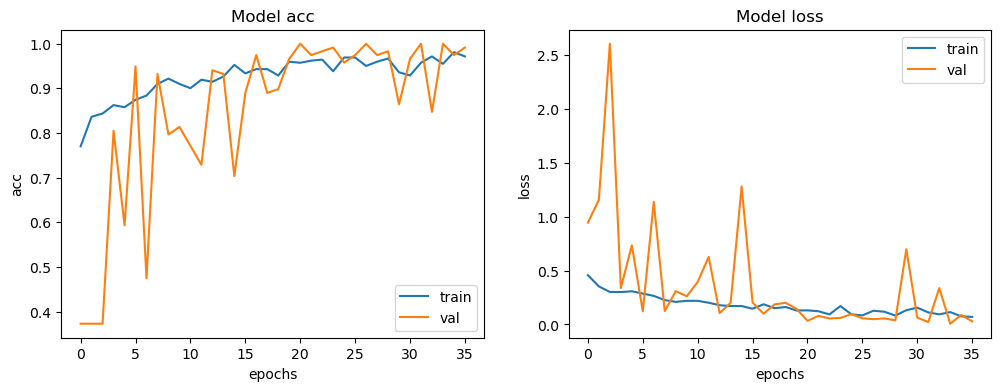

59/59 [==============================] - 2s 28ms/step - loss: 0.0066 - acc: 1.0000
Sample 37: The model predicted the MRI scan as intra, but the true class is inter.
Accuracy on test set: 98.28% (57/58 samples were correct).
tn: 19 fp: 1 fn: 0 tp: 38


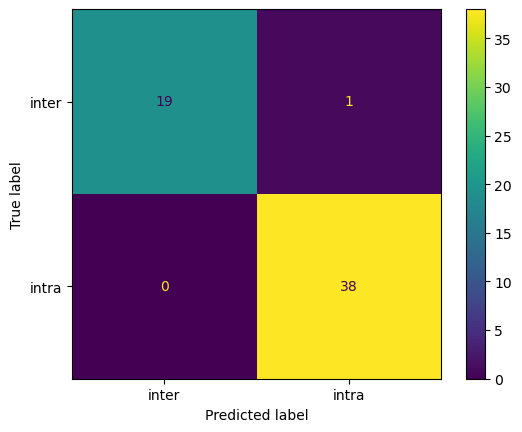

X_TRAIN (417, 128, 128, 64)
X_VAL (123, 128, 128, 64)


2024-04-06 18:06:56.371590: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session started.
2024-04-06 18:06:56.371625: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1408] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2024-04-06 18:06:56.371695: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1447] function cupti_interface_->ActivityRegisterCallbacks( AllocCuptiActivityBuffer, FreeCuptiActivityBuffer)failed with error CUPTI_ERROR_NOT_INITIALIZED
2024-04-06 18:06:56.371706: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1430] function cupti_interface_->EnableCallback( 0 , subscriber_, CUPTI_CB_DOMAIN_DRIVER_API, cbid)failed with error CUPTI_ERROR_INVALID_PARAMETER


Epoch 1/100

Epoch 00001: val_loss improved from inf to 2.99548, saving model to /home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/train_ia_r_no_overlap_1/model.h5
209/209 - 34s - loss: 0.4569 - acc: 0.7554 - val_loss: 2.9955 - val_acc: 0.3740
Epoch 2/100

Epoch 00002: val_loss did not improve from 2.99548
209/209 - 34s - loss: 0.3733 - acc: 0.8225 - val_loss: 5.0566 - val_acc: 0.3740
Epoch 3/100

Epoch 00003: val_loss improved from 2.99548 to 1.59306, saving model to /home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/train_ia_r_no_overlap_1/model.h5
209/209 - 33s - loss: 0.3530 - acc: 0.8177 - val_loss: 1.5931 - val_acc: 0.5447
Epoch 4/100

Epoch 00004: val_loss improved from 1.59306 to 0.16624, saving model to /home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/train_ia_r_no_overlap_1/model.h5
209/209 - 34s - loss: 0.3303 - acc: 0.8393 - val_loss: 0.1662 - val_acc: 0.9593
Epoch 5/100

Epoch 00005: val_lo

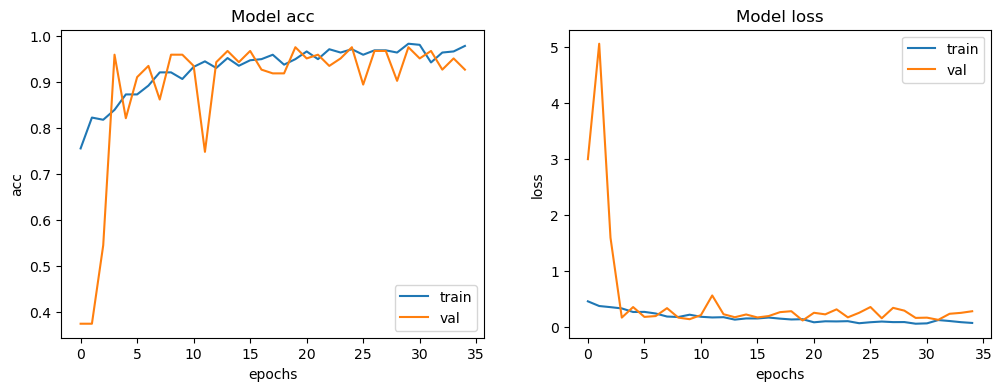

62/62 [==============================] - 2s 31ms/step - loss: 0.1151 - acc: 0.9756
Accuracy on test set: 100.00% (58/58 samples were correct).
tn: 49 fp: 0 fn: 0 tp: 9


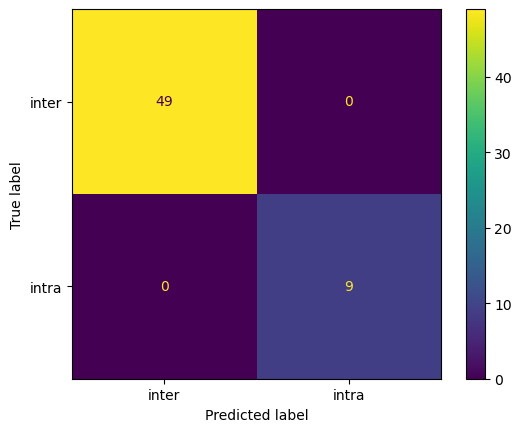

X_TRAIN (417, 128, 128, 64)
X_VAL (121, 128, 128, 64)


2024-04-06 18:27:29.737975: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session started.
2024-04-06 18:27:29.738011: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1408] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2024-04-06 18:27:29.738082: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1447] function cupti_interface_->ActivityRegisterCallbacks( AllocCuptiActivityBuffer, FreeCuptiActivityBuffer)failed with error CUPTI_ERROR_NOT_INITIALIZED
2024-04-06 18:27:29.738092: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1430] function cupti_interface_->EnableCallback( 0 , subscriber_, CUPTI_CB_DOMAIN_DRIVER_API, cbid)failed with error CUPTI_ERROR_INVALID_PARAMETER


Epoch 1/100

Epoch 00001: val_loss improved from inf to 1.03547, saving model to /home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/train_ia_r_no_overlap_2/model.h5
209/209 - 35s - loss: 0.4981 - acc: 0.7434 - val_loss: 1.0355 - val_acc: 0.3884
Epoch 2/100

Epoch 00002: val_loss improved from 1.03547 to 0.39802, saving model to /home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/train_ia_r_no_overlap_2/model.h5
209/209 - 35s - loss: 0.3763 - acc: 0.8201 - val_loss: 0.3980 - val_acc: 0.7934
Epoch 3/100

Epoch 00003: val_loss improved from 0.39802 to 0.37859, saving model to /home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/train_ia_r_no_overlap_2/model.h5
209/209 - 35s - loss: 0.3267 - acc: 0.8369 - val_loss: 0.3786 - val_acc: 0.8512
Epoch 4/100

Epoch 00004: val_loss improved from 0.37859 to 0.19962, saving model to /home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/train_ia_r_no

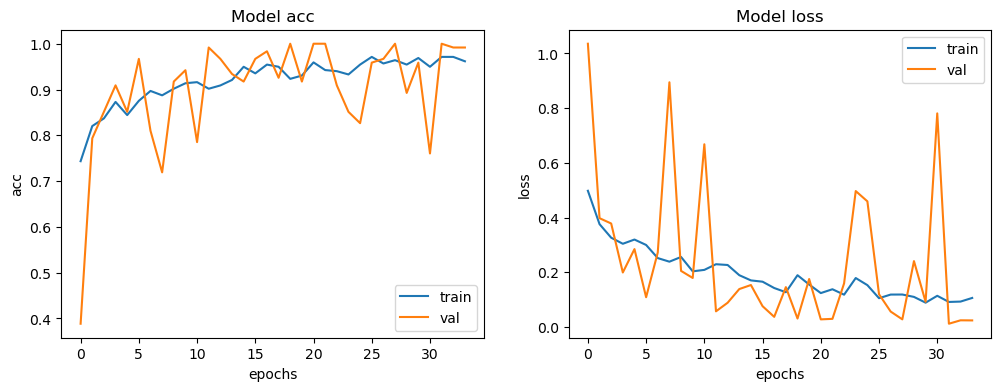

61/61 [==============================] - 2s 28ms/step - loss: 0.0124 - acc: 1.0000
Sample 15: The model predicted the MRI scan as inter, but the true class is intra.
Accuracy on test set: 98.33% (59/60 samples were correct).
tn: 25 fp: 0 fn: 1 tp: 34


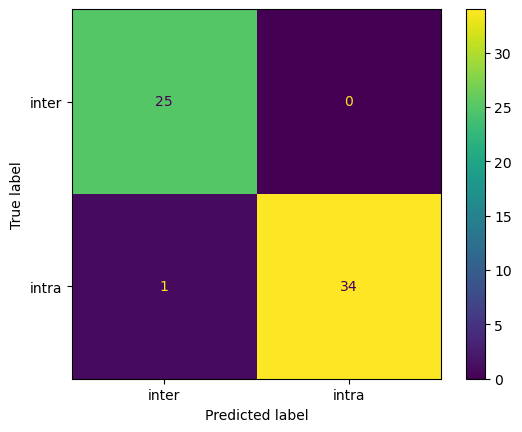

X_TRAIN (417, 128, 128, 64)
X_VAL (121, 128, 128, 64)


2024-04-06 18:47:24.826189: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session started.
2024-04-06 18:47:24.826224: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1408] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2024-04-06 18:47:24.826293: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1447] function cupti_interface_->ActivityRegisterCallbacks( AllocCuptiActivityBuffer, FreeCuptiActivityBuffer)failed with error CUPTI_ERROR_NOT_INITIALIZED
2024-04-06 18:47:24.826304: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1430] function cupti_interface_->EnableCallback( 0 , subscriber_, CUPTI_CB_DOMAIN_DRIVER_API, cbid)failed with error CUPTI_ERROR_INVALID_PARAMETER


Epoch 1/100

Epoch 00001: val_loss improved from inf to 1.50311, saving model to /home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/train_ia_r_no_overlap_3/model.h5
209/209 - 34s - loss: 0.4777 - acc: 0.7602 - val_loss: 1.5031 - val_acc: 0.4298
Epoch 2/100

Epoch 00002: val_loss did not improve from 1.50311
209/209 - 33s - loss: 0.3520 - acc: 0.8129 - val_loss: 4.8425 - val_acc: 0.4298
Epoch 3/100

Epoch 00003: val_loss improved from 1.50311 to 0.96369, saving model to /home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/train_ia_r_no_overlap_3/model.h5
209/209 - 34s - loss: 0.2989 - acc: 0.8441 - val_loss: 0.9637 - val_acc: 0.6281
Epoch 4/100

Epoch 00004: val_loss improved from 0.96369 to 0.26248, saving model to /home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/train_ia_r_no_overlap_3/model.h5
209/209 - 34s - loss: 0.3018 - acc: 0.8369 - val_loss: 0.2625 - val_acc: 0.8678
Epoch 5/100

Epoch 00005: val_lo

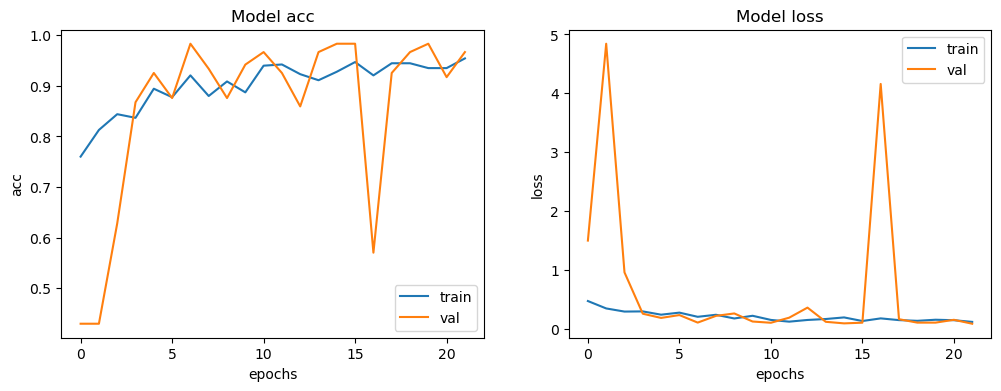

61/61 [==============================] - 2s 28ms/step - loss: 0.0928 - acc: 0.9669
Sample 52: The model predicted the MRI scan as inter, but the true class is intra.
Accuracy on test set: 98.33% (59/60 samples were correct).
tn: 28 fp: 0 fn: 1 tp: 31


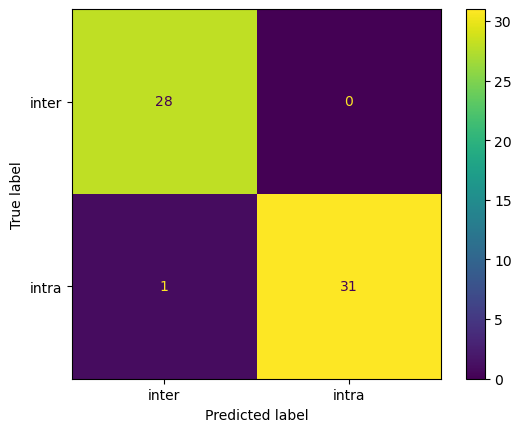

X_TRAIN (420, 128, 128, 64)
X_VAL (115, 128, 128, 64)


2024-04-06 19:00:11.105955: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session started.
2024-04-06 19:00:11.105992: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1408] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2024-04-06 19:00:11.106077: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1447] function cupti_interface_->ActivityRegisterCallbacks( AllocCuptiActivityBuffer, FreeCuptiActivityBuffer)failed with error CUPTI_ERROR_NOT_INITIALIZED
2024-04-06 19:00:11.106087: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1430] function cupti_interface_->EnableCallback( 0 , subscriber_, CUPTI_CB_DOMAIN_DRIVER_API, cbid)failed with error CUPTI_ERROR_INVALID_PARAMETER


Epoch 1/100

Epoch 00001: val_loss improved from inf to 3.02909, saving model to /home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/train_ia_r_no_overlap_4/model.h5
210/210 - 38s - loss: 0.4441 - acc: 0.7595 - val_loss: 3.0291 - val_acc: 0.3565
Epoch 2/100

Epoch 00002: val_loss improved from 3.02909 to 1.86982, saving model to /home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/train_ia_r_no_overlap_4/model.h5
210/210 - 37s - loss: 0.3969 - acc: 0.7738 - val_loss: 1.8698 - val_acc: 0.3565
Epoch 3/100

Epoch 00003: val_loss improved from 1.86982 to 0.36472, saving model to /home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/train_ia_r_no_overlap_4/model.h5
210/210 - 38s - loss: 0.3588 - acc: 0.7976 - val_loss: 0.3647 - val_acc: 0.8000
Epoch 4/100

Epoch 00004: val_loss did not improve from 0.36472
210/210 - 38s - loss: 0.2883 - acc: 0.8548 - val_loss: 0.5001 - val_acc: 0.8000
Epoch 5/100

Epoch 00005: val_lo

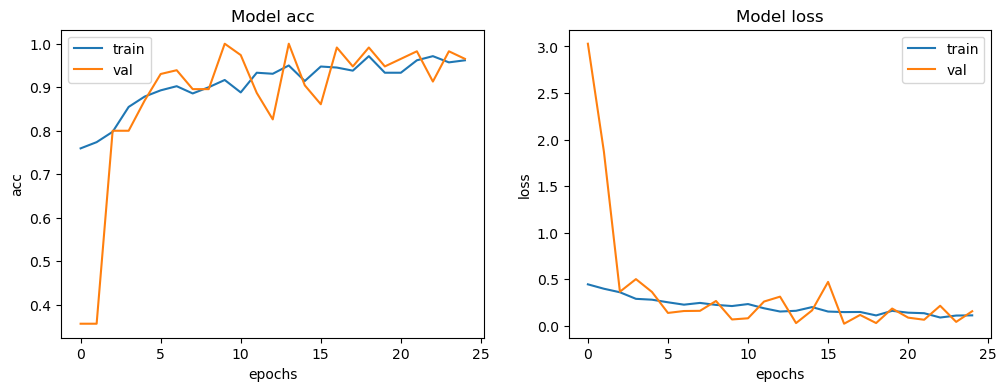

58/58 [==============================] - 2s 28ms/step - loss: 0.0210 - acc: 0.9913
Sample 0: The model predicted the MRI scan as inter, but the true class is intra.
Sample 13: The model predicted the MRI scan as inter, but the true class is intra.
Sample 58: The model predicted the MRI scan as inter, but the true class is intra.
Accuracy on test set: 95.24% (60/63 samples were correct).
tn: 18 fp: 0 fn: 3 tp: 42


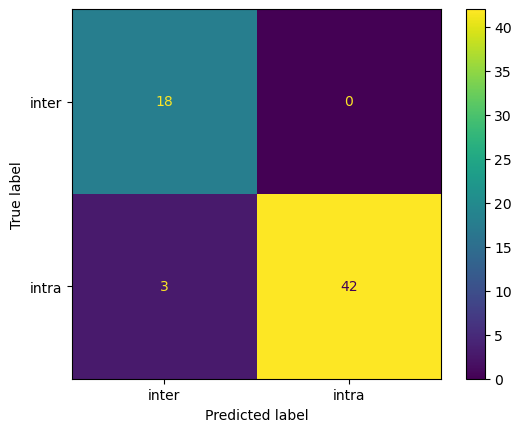

X_TRAIN (419, 128, 128, 64)
X_VAL (118, 128, 128, 64)


2024-04-06 19:15:33.066788: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session started.
2024-04-06 19:15:33.066823: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1408] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2024-04-06 19:15:33.066890: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1447] function cupti_interface_->ActivityRegisterCallbacks( AllocCuptiActivityBuffer, FreeCuptiActivityBuffer)failed with error CUPTI_ERROR_NOT_INITIALIZED
2024-04-06 19:15:33.066900: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1430] function cupti_interface_->EnableCallback( 0 , subscriber_, CUPTI_CB_DOMAIN_DRIVER_API, cbid)failed with error CUPTI_ERROR_INVALID_PARAMETER


Epoch 1/100

Epoch 00001: val_loss improved from inf to 0.87638, saving model to /home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/train_ia_r_no_overlap_5/model.h5
210/210 - 34s - loss: 0.4356 - acc: 0.7995 - val_loss: 0.8764 - val_acc: 0.3729
Epoch 2/100

Epoch 00002: val_loss did not improve from 0.87638
210/210 - 34s - loss: 0.3756 - acc: 0.8162 - val_loss: 1.5377 - val_acc: 0.3729
Epoch 3/100

Epoch 00003: val_loss did not improve from 0.87638
210/210 - 34s - loss: 0.3777 - acc: 0.7995 - val_loss: 1.1665 - val_acc: 0.5085
Epoch 4/100

Epoch 00004: val_loss did not improve from 0.87638
210/210 - 34s - loss: 0.3414 - acc: 0.8377 - val_loss: 2.1116 - val_acc: 0.4915
Epoch 5/100

Epoch 00005: val_loss improved from 0.87638 to 0.31003, saving model to /home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/train_ia_r_no_overlap_5/model.h5
210/210 - 34s - loss: 0.2917 - acc: 0.8640 - val_loss: 0.3100 - val_acc: 0.7797
Epoch 6/100

Epoch 0

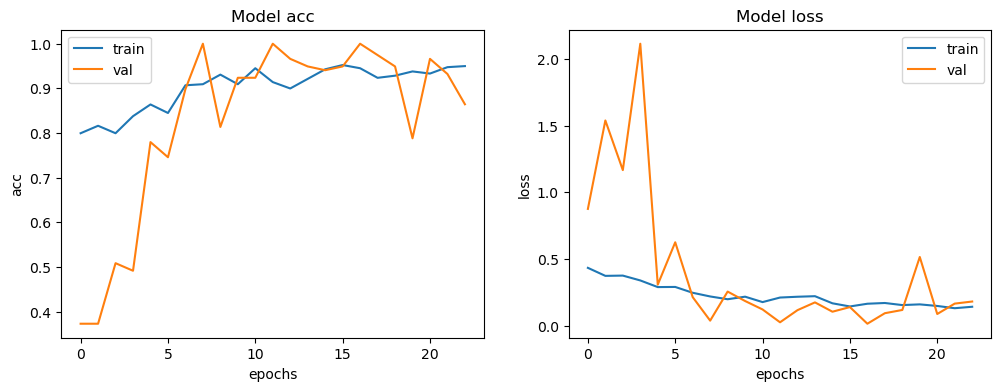

59/59 [==============================] - 2s 28ms/step - loss: 0.0177 - acc: 1.0000
Sample 18: The model predicted the MRI scan as intra, but the true class is inter.
Accuracy on test set: 98.36% (60/61 samples were correct).
tn: 23 fp: 1 fn: 0 tp: 37


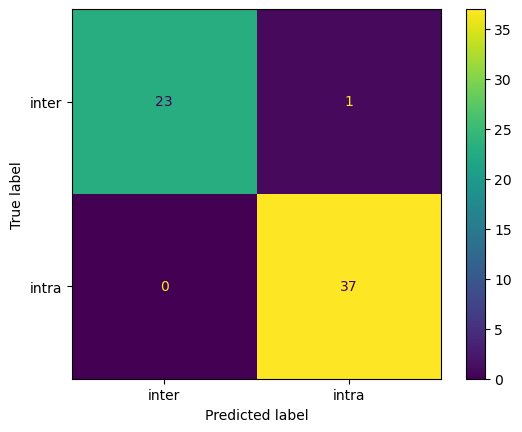

X_TRAIN (415, 128, 128, 64)
X_VAL (123, 128, 128, 64)


2024-04-06 19:28:59.388278: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session started.
2024-04-06 19:28:59.388315: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1408] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2024-04-06 19:28:59.388387: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1447] function cupti_interface_->ActivityRegisterCallbacks( AllocCuptiActivityBuffer, FreeCuptiActivityBuffer)failed with error CUPTI_ERROR_NOT_INITIALIZED
2024-04-06 19:28:59.388398: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1430] function cupti_interface_->EnableCallback( 0 , subscriber_, CUPTI_CB_DOMAIN_DRIVER_API, cbid)failed with error CUPTI_ERROR_INVALID_PARAMETER


Epoch 1/100

Epoch 00001: val_loss improved from inf to 3.11155, saving model to /home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/train_ia_r_no_overlap_6/model.h5
208/208 - 34s - loss: 0.4922 - acc: 0.7398 - val_loss: 3.1115 - val_acc: 0.3740
Epoch 2/100

Epoch 00002: val_loss did not improve from 3.11155
208/208 - 34s - loss: 0.3985 - acc: 0.7976 - val_loss: 6.7896 - val_acc: 0.3740
Epoch 3/100

Epoch 00003: val_loss improved from 3.11155 to 0.74636, saving model to /home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/train_ia_r_no_overlap_6/model.h5
208/208 - 33s - loss: 0.3739 - acc: 0.8241 - val_loss: 0.7464 - val_acc: 0.7073
Epoch 4/100

Epoch 00004: val_loss improved from 0.74636 to 0.19585, saving model to /home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/train_ia_r_no_overlap_6/model.h5
208/208 - 33s - loss: 0.3069 - acc: 0.8482 - val_loss: 0.1958 - val_acc: 0.9106
Epoch 5/100

Epoch 00005: val_lo

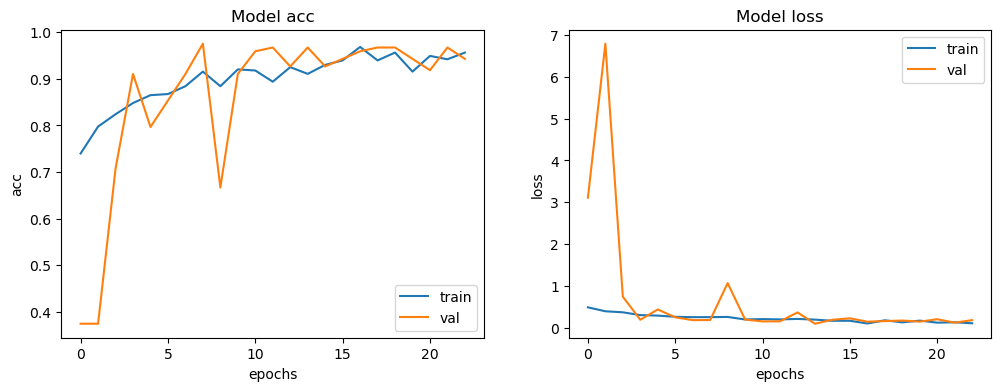

62/62 [==============================] - 2s 28ms/step - loss: 0.1009 - acc: 0.9675
Sample 54: The model predicted the MRI scan as intra, but the true class is inter.
Accuracy on test set: 98.33% (59/60 samples were correct).
tn: 22 fp: 1 fn: 0 tp: 37


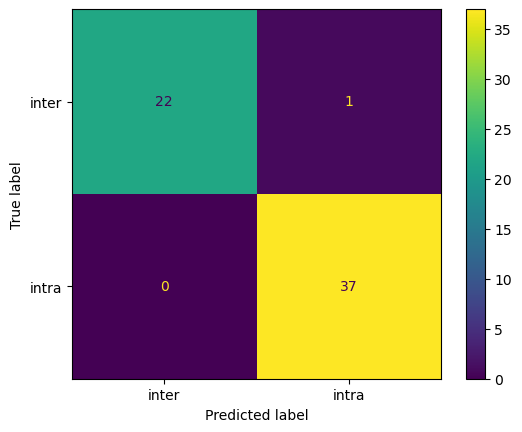

X_TRAIN (416, 128, 128, 64)
X_VAL (121, 128, 128, 64)


2024-04-06 19:42:19.828361: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session started.
2024-04-06 19:42:19.828399: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1408] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2024-04-06 19:42:19.828468: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1447] function cupti_interface_->ActivityRegisterCallbacks( AllocCuptiActivityBuffer, FreeCuptiActivityBuffer)failed with error CUPTI_ERROR_NOT_INITIALIZED
2024-04-06 19:42:19.828479: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1430] function cupti_interface_->EnableCallback( 0 , subscriber_, CUPTI_CB_DOMAIN_DRIVER_API, cbid)failed with error CUPTI_ERROR_INVALID_PARAMETER


Epoch 1/100

Epoch 00001: val_loss improved from inf to 0.76960, saving model to /home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/train_ia_r_no_overlap_7/model.h5
208/208 - 34s - loss: 0.4599 - acc: 0.7692 - val_loss: 0.7696 - val_acc: 0.3884
Epoch 2/100

Epoch 00002: val_loss did not improve from 0.76960
208/208 - 33s - loss: 0.3356 - acc: 0.8462 - val_loss: 1.0831 - val_acc: 0.3884
Epoch 3/100

Epoch 00003: val_loss did not improve from 0.76960
208/208 - 33s - loss: 0.3867 - acc: 0.7981 - val_loss: 1.2030 - val_acc: 0.4628
Epoch 4/100

Epoch 00004: val_loss improved from 0.76960 to 0.08815, saving model to /home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/train_ia_r_no_overlap_7/model.h5
208/208 - 34s - loss: 0.3181 - acc: 0.8678 - val_loss: 0.0881 - val_acc: 0.9917
Epoch 5/100

Epoch 00005: val_loss did not improve from 0.08815
208/208 - 34s - loss: 0.2926 - acc: 0.8750 - val_loss: 0.2086 - val_acc: 0.8512
Epoch 6/100

Epoch 0

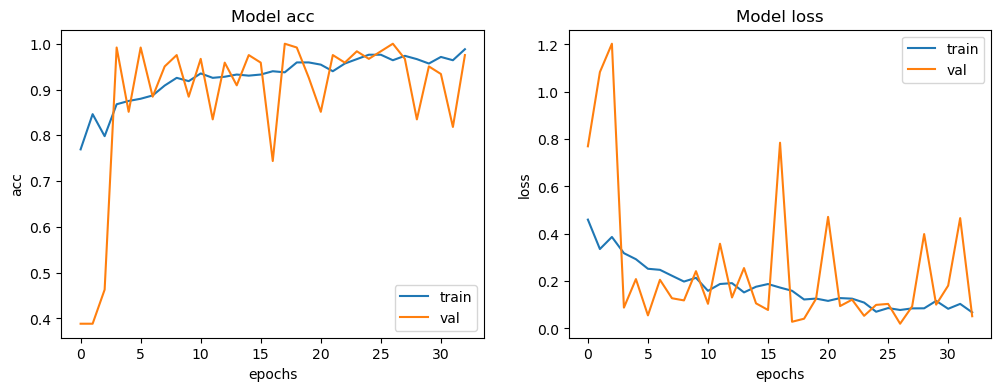

61/61 [==============================] - 2s 28ms/step - loss: 0.0201 - acc: 1.0000
Sample 14: The model predicted the MRI scan as inter, but the true class is intra.
Accuracy on test set: 98.36% (60/61 samples were correct).
tn: 33 fp: 0 fn: 1 tp: 27


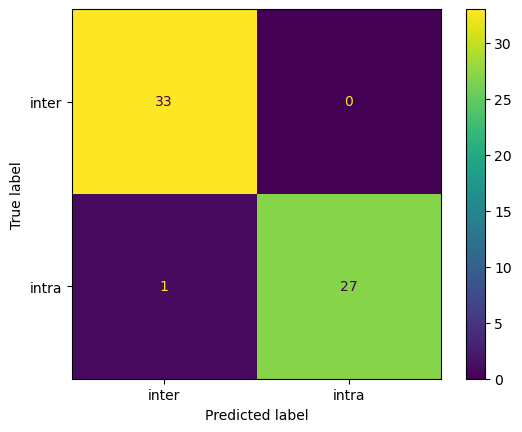

X_TRAIN (477, 128, 128, 64)
X_VAL (121, 128, 128, 64)


2024-04-06 20:01:27.557676: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session started.
2024-04-06 20:01:27.557716: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1408] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2024-04-06 20:01:27.557790: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1447] function cupti_interface_->ActivityRegisterCallbacks( AllocCuptiActivityBuffer, FreeCuptiActivityBuffer)failed with error CUPTI_ERROR_NOT_INITIALIZED
2024-04-06 20:01:27.557800: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1430] function cupti_interface_->EnableCallback( 0 , subscriber_, CUPTI_CB_DOMAIN_DRIVER_API, cbid)failed with error CUPTI_ERROR_INVALID_PARAMETER


Epoch 1/100

Epoch 00001: val_loss improved from inf to 1.00157, saving model to /home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/train_ia_r_no_overlap_8/model.h5
239/239 - 38s - loss: 0.4390 - acc: 0.7715 - val_loss: 1.0016 - val_acc: 0.5702
Epoch 2/100

Epoch 00002: val_loss did not improve from 1.00157
239/239 - 38s - loss: 0.3467 - acc: 0.8176 - val_loss: 2.5799 - val_acc: 0.4298
Epoch 3/100

Epoch 00003: val_loss did not improve from 1.00157
239/239 - 38s - loss: 0.3356 - acc: 0.8386 - val_loss: 1.2688 - val_acc: 0.4959
Epoch 4/100

Epoch 00004: val_loss improved from 1.00157 to 0.34018, saving model to /home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/train_ia_r_no_overlap_8/model.h5
239/239 - 38s - loss: 0.2640 - acc: 0.8763 - val_loss: 0.3402 - val_acc: 0.7769
Epoch 5/100

Epoch 00005: val_loss did not improve from 0.34018
239/239 - 38s - loss: 0.2930 - acc: 0.8763 - val_loss: 0.4163 - val_acc: 0.7521
Epoch 6/100

Epoch 0

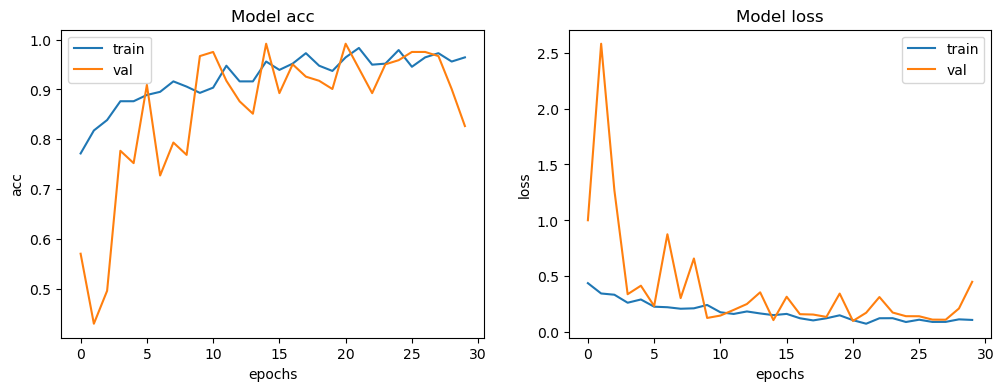

61/61 [==============================] - 2s 28ms/step - loss: 0.1011 - acc: 0.9917
Sample 59: The model predicted the MRI scan as inter, but the true class is intra.
Accuracy on test set: 98.33% (59/60 samples were correct).
tn: 19 fp: 0 fn: 1 tp: 40


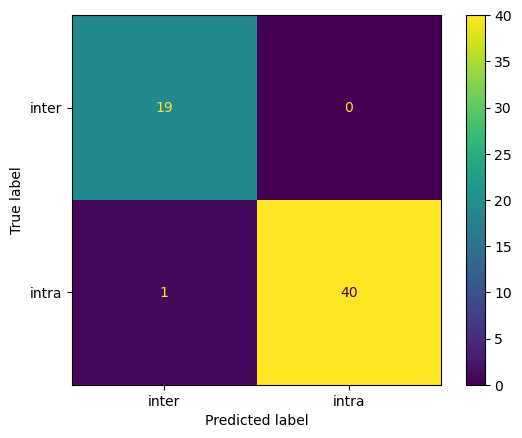

X_TRAIN (483, 128, 128, 64)
X_VAL (115, 128, 128, 64)


2024-04-06 20:21:12.740905: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session started.
2024-04-06 20:21:12.740939: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1408] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2024-04-06 20:21:12.741009: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1447] function cupti_interface_->ActivityRegisterCallbacks( AllocCuptiActivityBuffer, FreeCuptiActivityBuffer)failed with error CUPTI_ERROR_NOT_INITIALIZED
2024-04-06 20:21:12.741019: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1430] function cupti_interface_->EnableCallback( 0 , subscriber_, CUPTI_CB_DOMAIN_DRIVER_API, cbid)failed with error CUPTI_ERROR_INVALID_PARAMETER


Epoch 1/100

Epoch 00001: val_loss improved from inf to 2.38515, saving model to /home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/train_ia_r_no_overlap_9/model.h5
242/242 - 39s - loss: 0.4912 - acc: 0.7081 - val_loss: 2.3851 - val_acc: 0.3565
Epoch 2/100

Epoch 00002: val_loss improved from 2.38515 to 0.48866, saving model to /home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/train_ia_r_no_overlap_9/model.h5
242/242 - 39s - loss: 0.4150 - acc: 0.7681 - val_loss: 0.4887 - val_acc: 0.6522
Epoch 3/100

Epoch 00003: val_loss improved from 0.48866 to 0.45362, saving model to /home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/train_ia_r_no_overlap_9/model.h5
242/242 - 39s - loss: 0.3470 - acc: 0.8199 - val_loss: 0.4536 - val_acc: 0.7391
Epoch 4/100

Epoch 00004: val_loss improved from 0.45362 to 0.37741, saving model to /home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/train_ia_r_no

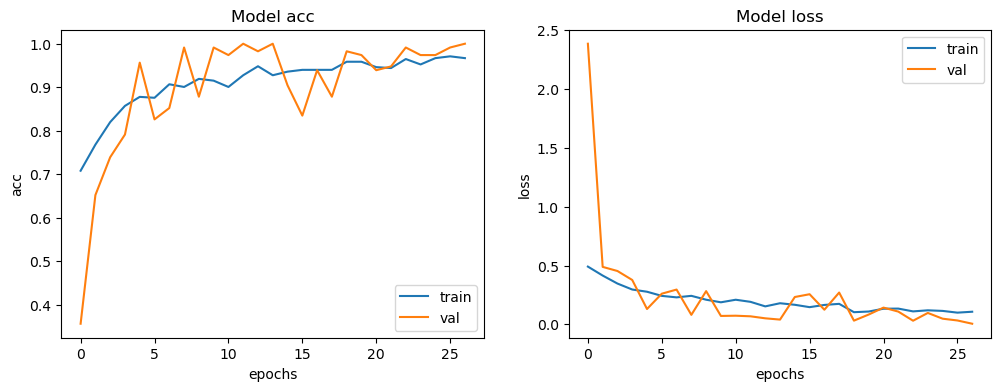

58/58 [==============================] - 2s 28ms/step - loss: 0.0056 - acc: 1.0000
Accuracy on test set: 100.00% (57/57 samples were correct).
tn: 21 fp: 0 fn: 0 tp: 36


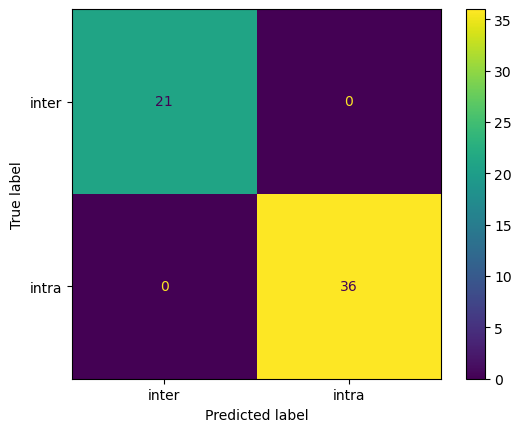

validation accuracy [1.0, 0.9756097793579102, 1.0, 0.9669421315193176, 0.991304337978363, 1.0, 0.9674796462059021, 1.0, 0.9917355179786682, 1.0]
test accuracy [0.9827586206896551, 1.0, 0.9833333333333333, 0.9833333333333333, 0.9523809523809523, 0.9836065573770492, 0.9833333333333333, 0.9836065573770492, 0.9833333333333333, 1.0]
test f1_score [0.9870129870129869, 1.0, 0.9855072463768115, 0.9841269841269841, 0.9655172413793104, 0.9866666666666666, 0.9866666666666666, 0.9818181818181818, 0.9876543209876543, 1.0]
mean validation accuracy 0.9893071413040161 0.013212959064879789
mean test accuracy 0.9835686021158038 0.012302566909209455
mean f1 score 0.9864970295035264 0.009137633308722571


In [108]:
# Train + Test NO OVERLAP

epochs = 100
train_iteration_names = [f'{experiment_name}_no_overlap_{i}' for i in range(10)]

VALIDATION_ACCURACY = []
VALIDATION_LOSS = []
TEST_ACCURACY = []
TEST_F1_SCORE = []
x_train_size = []
x_val_size = []
x_test_size = []
y_train_size = []
y_val_size = []
y_test_size = []

nbr_sets = 10
train_indices_list, val_indices_list, test_indices_list = split_into_indices(all_sets, nbr_sets)

# Preprocess all images first
all_intra_scans = np.array(intra_scan_paths)
all_inter_scans = np.array(inter_scan_paths)
intra_labels = np.array([1] * len(all_intra_scans))
inter_labels = np.array([0] * len(all_inter_scans))
all_labels = np.concatenate((intra_labels, inter_labels), axis=0)

processed_intra_scans = np.array([process_scan(path) for path in all_intra_scans])
processed_inter_scans = np.array([process_scan(path) for path in all_inter_scans])
processed_all_scans = np.concatenate((processed_intra_scans, processed_inter_scans), axis=0)

for train_iteration_name in train_iteration_names:
    split_nbr = int(re.search(r'\d+', train_iteration_name).group())

    # Obtain splits
    x_train, y_train = processed_all_scans[train_indices_list[split_nbr]], all_labels[train_indices_list[split_nbr]]
    x_val, y_val = processed_all_scans[val_indices_list[split_nbr]], all_labels[val_indices_list[split_nbr]]
    x_test, y_test = processed_all_scans[test_indices_list[split_nbr]], all_labels[test_indices_list[split_nbr]]
    
    print('X_TRAIN', x_train.shape)
    x_train_size.append(x_train.shape[0])
    y_train_size.append(((y_train==0).sum(), (y_train==1).sum()))
    print('X_VAL', x_val.shape)
    x_val_size.append(x_val.shape[0])
    y_val_size.append(((y_val==0).sum(), (y_val==1).sum()))
    print('X_TEST', x_test.shape)
    x_test_size.append(x_test.shape[0])
    y_test_size.append(((y_test==0).sum(), (y_test==1).sum()))
    
    train_dataset, validation_dataset = data_loaders(x_train, y_train, x_val, y_val, batch_size=2)
    # Create new model
    model = get_model(width=128, height=128, depth=64)
    
    train_dir, callbacks_list, model = train_no_overlap(model, train_dataset, validation_dataset, epochs, train_iteration_name)

    visualize_model_performance(model, train_dir)
    # LOAD BEST MODEL to evaluate the performance of the model
    model.load_weights(f'{train_dir}/model.h5')
	
    results = model.evaluate(validation_dataset)
    results = dict(zip(model.metrics_names,results))

    accuracy, f1_score_calc = calculate_accuracy_test_set(model, x_test, y_test, train_dir)
	
    VALIDATION_ACCURACY.append(results['acc'])
    VALIDATION_LOSS.append(results['loss'])
    TEST_ACCURACY.append(accuracy)
    TEST_F1_SCORE.append(f1_score_calc)
    tf.keras.backend.clear_session()

print('validation accuracy', VALIDATION_ACCURACY)
print('test accuracy', TEST_ACCURACY)
print('test f1_score', TEST_F1_SCORE)
print('mean validation accuracy', np.mean(VALIDATION_ACCURACY), np.std(VALIDATION_ACCURACY))
print('mean test accuracy', np.mean(TEST_ACCURACY), np.std(TEST_ACCURACY))
print('mean f1 score', np.mean(TEST_F1_SCORE), np.std(TEST_F1_SCORE))

In [119]:
len(processed_all_scans)

867

In [121]:
processed_all_scans[0].shape

(128, 128, 64)

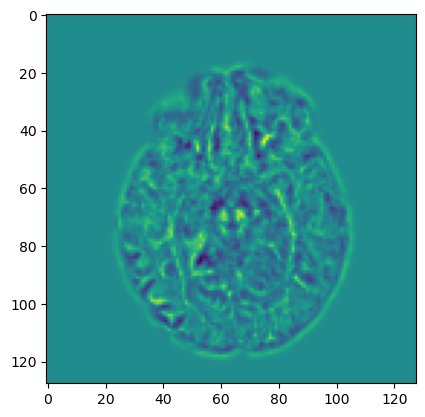

In [189]:
plt.imshow(processed_all_scans[0][:, :, 32])

In [183]:
def calculate_average_log_jacobian(volume):
    # Iterate through the image_3d and store the absolute values of all elements in abs_values
    abs_values = np.abs(volume)

    # Calculate the average of the absolute values
    average_absolute = np.mean(abs_values)

    return average_absolute

In [190]:
all_paths = np.concatenate((all_intra_scans, all_inter_scans), axis=0)

In [191]:
all_paths[0]

'/home/andjela/Documents/intra-inter-ddfs/intra_mix_r/PS15_012_PS16_022/logJacobian.nii.gz'

In [1]:
# Initialize an empty list to store dictionaries
data = []

# Loop through the processed scans
for count, volume in enumerate(processed_all_scans):
    avg_abs_log_jacobian = calculate_average_log_jacobian(volume)
    components = [component for component in iter(lambda: os.path.split(all_paths[count])[1], '')]
    scan_id_1, scan_id_2 = find_scan_ids(components[-2])
    
    # Append data to the list
    data.append({'scan_id_1': scan_id_1, 'scan_id_2': scan_id_2, 'avg_abs_log_jacobian': avg_abs_log_jacobian})

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv(f'full_logJac_{experiment_name}_NO.csv', index=False)

NameError: name 'processed_all_scans' is not defined

In [184]:

def df_logJac(data, experiment_name, scenario):
    df_logJac = pd.DataFrame(columns=['scan_id_1', 'scan_id_2', 'age_interval', 'avg_abs_log_jacobian', 'group'])

    for sets in all_sets:
        idxes = list(sets)
        for i in idxes:
            participant_ids_scan_ids = all_participant_ids_and_scan_ids[i]
            # Intra case
            if participant_ids_scan_ids[0][0] == participant_ids_scan_ids[0][1]:
                group = 'intra'
                specific_scan_id_1 = participant_ids_scan_ids[1][0]
                specific_scan_id_2 = participant_ids_scan_ids[1][1]
                # Filter the DataFrame to retrieve the ages for the specific scan IDs
                try:
                    age_for_scan_id_1 = full_df.loc[full_df['scan_id'] == specific_scan_id_1, 'age'].iloc[0]
                    age_for_scan_id_2 = full_df.loc[full_df['scan_id'] == specific_scan_id_2, 'age'].iloc[0]
                except Exception as e:
                    print(specific_scan_id_1, specific_scan_id_2)
                age_interval = np.abs(age_for_scan_id_2 - age_for_scan_id_1)
                avg_abs_log_jacobian = calculate_average_log_jacobian(data[i])
                df_logJac = df_logJac.append({'scan_id_1': specific_scan_id_1, 'scan_id_2': specific_scan_id_2, 'age_interval': age_interval, 'avg_abs_log_jacobian': avg_abs_log_jacobian, 'group': group}, ignore_index=True)
            elif participant_ids_scan_ids[0][0] != participant_ids_scan_ids[0][1]:
                group = 'inter'
                specific_scan_id_1 = participant_ids_scan_ids[1][0]
                specific_scan_id_2 = participant_ids_scan_ids[1][1]
                # Filter the DataFrame to retrieve the ages for the specific scan IDs
                try:
                    age_for_scan_id_1 = full_df.loc[full_df['scan_id'] == specific_scan_id_1, 'age'].iloc[0]
                    age_for_scan_id_2 = full_df.loc[full_df['scan_id'] == specific_scan_id_2, 'age'].iloc[0]
                except Exception as e:
                    print(participant_ids_scan_ids[0][0])
                    print(specific_scan_id_1, specific_scan_id_2)
                age_interval = np.abs(age_for_scan_id_2 - age_for_scan_id_1)
                avg_abs_log_jacobian = calculate_average_log_jacobian(data[i])
                df_logJac = df_logJac.append({'scan_id_1': specific_scan_id_1, 'scan_id_2': specific_scan_id_2, 'age_interval': age_interval, 'avg_abs_log_jacobian': avg_abs_log_jacobian, 'group': group}, ignore_index=True)
            else:
                print('Other scenario')
    df_logJac.to_csv(f'logJac_{experiment_name}_{scenario}.csv', index=False)

In [185]:
df_logJac(processed_all_scans, experiment_name, 'NO')

#### Training with overlaps in terms of patients

In [186]:

# Set a random seed for reproducibility
random_state = 42
np.random.seed(random_state)  # You can use any integer value

# Read and process the scans only when the train, val, test sets are selected.
# Each scan is then resized across height, width, and depth and rescaled.
intra_scans = np.array(intra_scan_paths)
inter_scans = np.array(inter_scan_paths)

# For the MRI scans having a logJacobian derived from intra reg assign 1, 
# for inter assign 0.
intra_labels = np.array([1 for _ in range(len(intra_scans))])
inter_labels = np.array([0 for _ in range(len(inter_scans))])

X = np.concatenate((intra_scans, inter_scans), axis=0)
y = np.concatenate((intra_labels, inter_labels), axis=0)

# Number of indices to be selected to match the no_overlap training
# num_indices = 305
num_indices = 538
# num_indices = 598

# Randomly select indices from the first 434 elements (intra part)
first_indices = np.random.choice(nbr_intra_pairs, size=num_indices // 2, replace=False)

# Randomly select indices from the last 421 elements
last_indices = np.random.choice(range(nbr_intra_pairs, len(y)), size=num_indices - len(first_indices), replace=False)

# Concatenate both sets of indices
selected_indices = np.concatenate((first_indices, last_indices))

# Shuffle the indices using the random state
rng = np.random.default_rng(random_state)
rng.shuffle(selected_indices)

selected_train_paths = [X[i] for i in selected_indices]
train_data = np.array([process_scan(path) for path in selected_train_paths])
y_data = y[selected_indices]

print(y_data)


[1 0 1 0 1 1 1 0 0 1 1 1 0 0 1 1 1 0 0 1 0 1 1 1 0 1 1 1 0 0 0 0 1 1 1 0 0
 1 1 1 0 0 1 0 1 0 1 0 1 0 1 0 0 0 0 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1 1 1 1 1
 1 1 0 0 1 1 0 0 0 0 1 1 1 1 0 1 1 0 0 1 1 1 1 0 1 1 0 1 1 0 1 0 0 1 0 0 1
 0 0 1 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 1 1 1 1 1 0 1 1 0 0 0 0 1 1 1 0
 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 1 0 1 0 0 0 0 1 1 0
 0 1 1 1 1 1 1 1 0 0 0 1 1 1 0 0 0 0 0 0 1 0 1 1 0 1 1 0 0 0 0 1 0 0 0 1 0
 0 0 0 0 0 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 0 1 0 1 0 1 0 0 1 0 0 1 0 1 0 0 0
 1 1 1 0 0 1 1 1 0 1 0 1 0 1 0 0 1 1 1 0 1 1 0 0 1 1 0 1 0 1 1 0 0 1 0 0 0
 1 1 0 1 0 0 0 1 1 1 0 1 0 0 1 0 1 1 0 0 1 0 1 0 1 0 0 1 1 0 1 1 0 1 1 1 0
 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 1 1 1 0 1 1 1 1 1 0 1 0 0 0 1 1 0 0 1 0 0
 0 1 1 1 0 1 0 0 0 1 0 1 0 1 0 1 1 1 0 1 0 1 0 0 0 0 1 0 0 1 0 1 1 0 0 0 1
 1 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1 0 1 1
 1 0 0 1 1 1 1 1 0 0 0 0 0 1 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 0 1 1 0 1 1 1 0
 1 1 1 1 1 0 0 1 0 0 0 1 

In [187]:
np.bincount(y_data)

array([269, 269])

In [150]:
selected_train_paths[:5]

['/home/andjela/joplin-intra-inter/inter_ia_r/PS15_106_PS16_033/logJacobian.nii.gz',
 '/home/andjela/joplin-intra-inter/inter_ia_r/PS17_002_PS16_069/logJacobian.nii.gz',
 '/home/andjela/joplin-intra-inter/inter_ia_r/CL_Dev_012_PS16_074/logJacobian.nii.gz',
 '/home/andjela/Documents/intra-inter-ddfs/intra_mix_r/PS14_073_PS15_116/logJacobian.nii.gz',
 '/home/andjela/Documents/intra-inter-ddfs/intra_mix_r/PS14_060_PS14_123/logJacobian.nii.gz']

In [188]:
scenario = 'O'
df_logJac = pd.DataFrame(columns=['scan_id_1', 'scan_id_2', 'age_interval', 'avg_abs_log_jacobian', 'group'])


for count, i in enumerate(selected_indices):
    participant_ids_scan_ids = all_participant_ids_and_scan_ids[i]
    # Intra case
    if participant_ids_scan_ids[0][0] == participant_ids_scan_ids[0][1]:
        group = 'intra'
        specific_scan_id_1 = participant_ids_scan_ids[1][0]
        specific_scan_id_2 = participant_ids_scan_ids[1][1]
        # Filter the DataFrame to retrieve the ages for the specific scan IDs
        try:
            age_for_scan_id_1 = full_df.loc[full_df['scan_id'] == specific_scan_id_1, 'age'].iloc[0]
            age_for_scan_id_2 = full_df.loc[full_df['scan_id'] == specific_scan_id_2, 'age'].iloc[0]
        except Exception as e:
            print(specific_scan_id_1, specific_scan_id_2)
        age_interval = np.abs(age_for_scan_id_2 - age_for_scan_id_1)
        avg_abs_log_jacobian = calculate_average_log_jacobian(train_data[count])
        df_logJac = df_logJac.append({'scan_id_1': specific_scan_id_1, 'scan_id_2': specific_scan_id_2, 'age_interval': age_interval, 'avg_abs_log_jacobian': avg_abs_log_jacobian, 'group': group}, ignore_index=True)
    elif participant_ids_scan_ids[0][0] != participant_ids_scan_ids[0][1]:
        group = 'inter'
        specific_scan_id_1 = participant_ids_scan_ids[1][0]
        specific_scan_id_2 = participant_ids_scan_ids[1][1]
        # Filter the DataFrame to retrieve the ages for the specific scan IDs
        try:
            age_for_scan_id_1 = full_df.loc[full_df['scan_id'] == specific_scan_id_1, 'age'].iloc[0]
            age_for_scan_id_2 = full_df.loc[full_df['scan_id'] == specific_scan_id_2, 'age'].iloc[0]
        except Exception as e:
            print(participant_ids_scan_ids[0][0])
            print(specific_scan_id_1, specific_scan_id_2)
        age_interval = np.abs(age_for_scan_id_2 - age_for_scan_id_1)
        avg_abs_log_jacobian = calculate_average_log_jacobian(train_data[count])
        df_logJac = df_logJac.append({'scan_id_1': specific_scan_id_1, 'scan_id_2': specific_scan_id_2, 'age_interval': age_interval, 'avg_abs_log_jacobian': avg_abs_log_jacobian, 'group': group}, ignore_index=True)
    else:
        print('Other scenario')
    df_logJac.to_csv(f'logJac_{experiment_name}_{scenario}.csv', index=False)

In [111]:
from sklearn.model_selection import KFold, train_test_split
from collections import Counter

fold_var = 0
kf = KFold(n_splits=10, shuffle=True, random_state=random_state)

for train_index, test_index in kf.split(train_data):
    # Further split the training data into 70% training and 30% validation
    new_train_index, val_index = train_test_split(train_index, test_size=0.3, random_state=random_state)
    
    x_train, y_train = train_data[new_train_index], y_data[new_train_index]
    x_val, y_val = train_data[val_index], y_data[val_index]
    x_test, y_test = train_data[test_index], y_data[test_index]
    print(fold_var)
    

    # Mapping dictionary for 0 and 1
    mapping = {0: 'inter', 1: 'intra'}

    for y, y_name in zip([y_train, y_val, y_test], ['y_train', 'y_val', 'y_test']):
        # Map the values
        mapped_y = [mapping[val] for val in y]

        # Count occurrences of each value in the list
        counts = Counter(mapped_y)
        # Calculate ratios
        total_length = len(y)
        ratios = ratios = {key: count / total_length for key, count in counts.items()}

        # Display variable names, counts, and ratios
        print(f"Variable: {y_name}")
        print("Counts:", counts)
        print("Ratios:", ratios)
        print('--------------------------------------------------------------------')
    fold_var += 1



0
Variable: y_train
Counts: Counter({'intra': 189, 'inter': 187})
Ratios: {'inter': 0.4973404255319149, 'intra': 0.5026595744680851}
--------------------------------------------------------------------
Variable: y_val
Counts: Counter({'intra': 86, 'inter': 76})
Ratios: {'intra': 0.5308641975308642, 'inter': 0.4691358024691358}
--------------------------------------------------------------------
Variable: y_test
Counts: Counter({'inter': 36, 'intra': 24})
Ratios: {'inter': 0.6, 'intra': 0.4}
--------------------------------------------------------------------
1
Variable: y_train
Counts: Counter({'inter': 192, 'intra': 184})
Ratios: {'intra': 0.48936170212765956, 'inter': 0.5106382978723404}
--------------------------------------------------------------------
Variable: y_val
Counts: Counter({'intra': 84, 'inter': 78})
Ratios: {'inter': 0.48148148148148145, 'intra': 0.5185185185185185}
--------------------------------------------------------------------
Variable: y_test
Counts: Counter({'

In [112]:
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

Epoch 1/100

Epoch 00001: val_loss improved from inf to 1.96517, saving model to /home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/train_ia_r_overlap_0/model_0.h5
188/188 - 35s - loss: 0.5054 - acc: 0.7181 - val_loss: 1.9652 - val_acc: 0.4691
Epoch 2/100

Epoch 00002: val_loss did not improve from 1.96517
188/188 - 33s - loss: 0.4227 - acc: 0.7606 - val_loss: 3.3418 - val_acc: 0.4691
Epoch 3/100

Epoch 00003: val_loss improved from 1.96517 to 0.71423, saving model to /home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/train_ia_r_overlap_0/model_0.h5
188/188 - 33s - loss: 0.3452 - acc: 0.8059 - val_loss: 0.7142 - val_acc: 0.5679
Epoch 4/100

Epoch 00004: val_loss improved from 0.71423 to 0.22968, saving model to /home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/train_ia_r_overlap_0/model_0.h5
188/188 - 33s - loss: 0.3533 - acc: 0.8271 - val_loss: 0.2297 - val_acc: 0.8889
Epoch 5/100

Epoch 00005: val_loss 

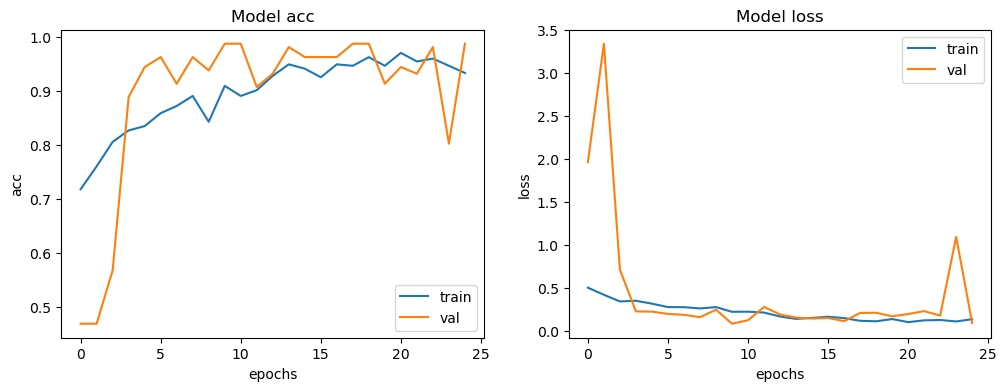

81/81 [==============================] - 2s 28ms/step - loss: 0.0862 - acc: 0.9877
Accuracy on test set: 100.00% (60/60 samples were correct).
tn: 36 fp: 0 fn: 0 tp: 24


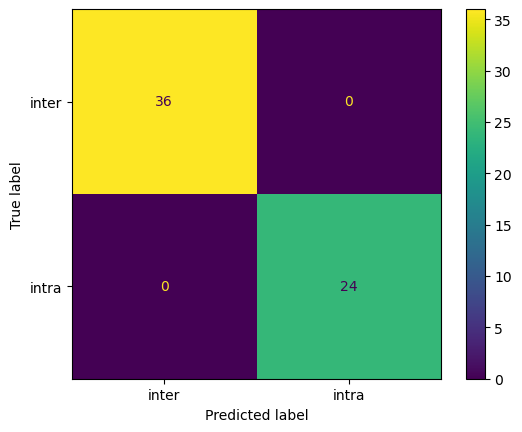

Epoch 1/100

Epoch 00001: val_loss improved from inf to 0.73208, saving model to /home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/train_ia_r_overlap_1/model_1.h5
188/188 - 31s - loss: 0.5133 - acc: 0.7048 - val_loss: 0.7321 - val_acc: 0.4815
Epoch 2/100

Epoch 00002: val_loss did not improve from 0.73208
188/188 - 31s - loss: 0.3908 - acc: 0.7952 - val_loss: 1.8346 - val_acc: 0.4815
Epoch 3/100

Epoch 00003: val_loss improved from 0.73208 to 0.69605, saving model to /home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/train_ia_r_overlap_1/model_1.h5
188/188 - 31s - loss: 0.3486 - acc: 0.8404 - val_loss: 0.6961 - val_acc: 0.6173
Epoch 4/100

Epoch 00004: val_loss improved from 0.69605 to 0.33012, saving model to /home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/train_ia_r_overlap_1/model_1.h5
188/188 - 31s - loss: 0.3752 - acc: 0.8298 - val_loss: 0.3301 - val_acc: 0.8272
Epoch 5/100

Epoch 00005: val_loss 

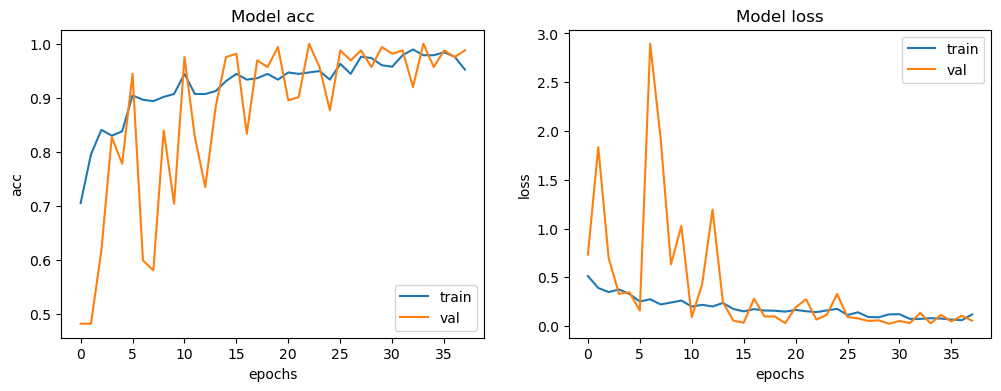

81/81 [==============================] - 2s 28ms/step - loss: 0.0244 - acc: 0.9938
Accuracy on test set: 100.00% (60/60 samples were correct).
tn: 29 fp: 0 fn: 0 tp: 31


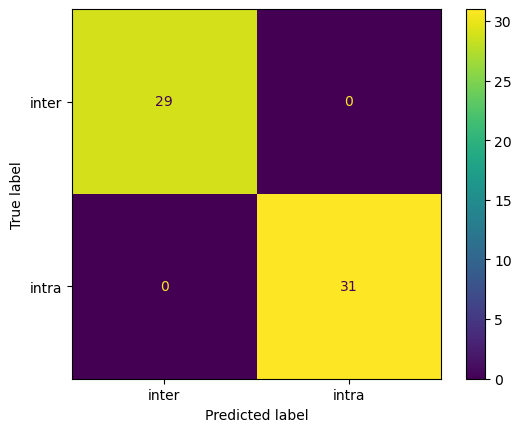

Epoch 1/100

Epoch 00001: val_loss improved from inf to 1.16173, saving model to /home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/train_ia_r_overlap_2/model_2.h5
188/188 - 31s - loss: 0.5296 - acc: 0.7021 - val_loss: 1.1617 - val_acc: 0.4383
Epoch 2/100

Epoch 00002: val_loss did not improve from 1.16173
188/188 - 31s - loss: 0.4283 - acc: 0.7660 - val_loss: 3.0368 - val_acc: 0.4383
Epoch 3/100

Epoch 00003: val_loss improved from 1.16173 to 0.58156, saving model to /home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/train_ia_r_overlap_2/model_2.h5
188/188 - 31s - loss: 0.3705 - acc: 0.7926 - val_loss: 0.5816 - val_acc: 0.5556
Epoch 4/100

Epoch 00004: val_loss improved from 0.58156 to 0.09832, saving model to /home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/train_ia_r_overlap_2/model_2.h5
188/188 - 31s - loss: 0.3580 - acc: 0.8112 - val_loss: 0.0983 - val_acc: 0.9877
Epoch 5/100

Epoch 00005: val_loss 

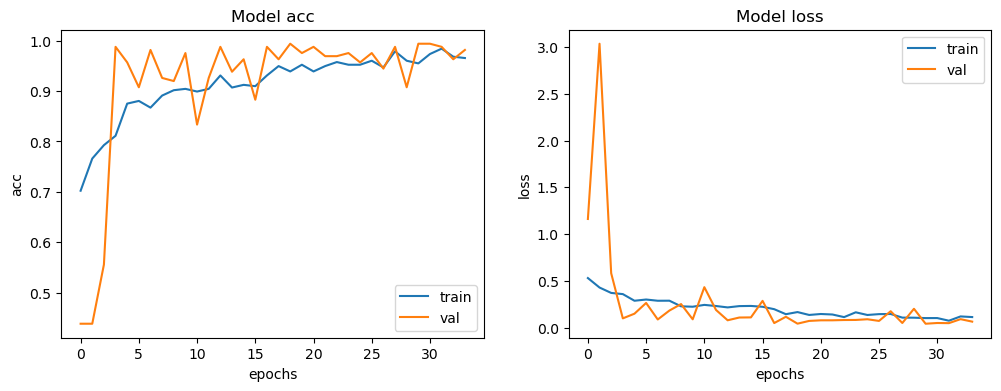

81/81 [==============================] - 2s 28ms/step - loss: 0.0411 - acc: 0.9938
Sample 29: The model predicted the MRI scan as inter, but the true class is intra.
Sample 47: The model predicted the MRI scan as inter, but the true class is intra.
Accuracy on test set: 96.67% (58/60 samples were correct).
tn: 29 fp: 0 fn: 2 tp: 29


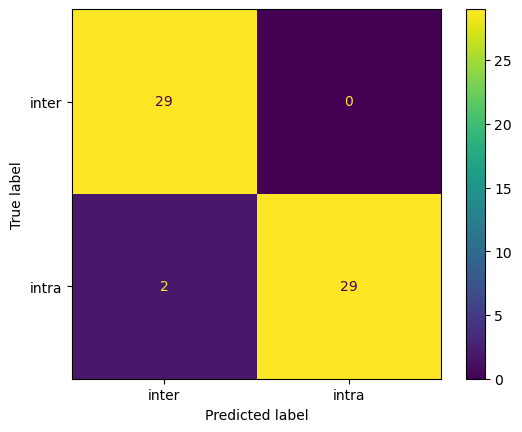

Epoch 1/100

Epoch 00001: val_loss improved from inf to 2.35416, saving model to /home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/train_ia_r_overlap_3/model_3.h5
188/188 - 31s - loss: 0.5082 - acc: 0.7207 - val_loss: 2.3542 - val_acc: 0.5370
Epoch 2/100

Epoch 00002: val_loss did not improve from 2.35416
188/188 - 31s - loss: 0.4114 - acc: 0.8032 - val_loss: 4.3678 - val_acc: 0.5370
Epoch 3/100

Epoch 00003: val_loss did not improve from 2.35416
188/188 - 31s - loss: 0.3542 - acc: 0.8218 - val_loss: 3.0203 - val_acc: 0.5370
Epoch 4/100

Epoch 00004: val_loss improved from 2.35416 to 0.26440, saving model to /home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/train_ia_r_overlap_3/model_3.h5
188/188 - 31s - loss: 0.3643 - acc: 0.8032 - val_loss: 0.2644 - val_acc: 0.8765
Epoch 5/100

Epoch 00005: val_loss improved from 0.26440 to 0.20771, saving model to /home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/tra

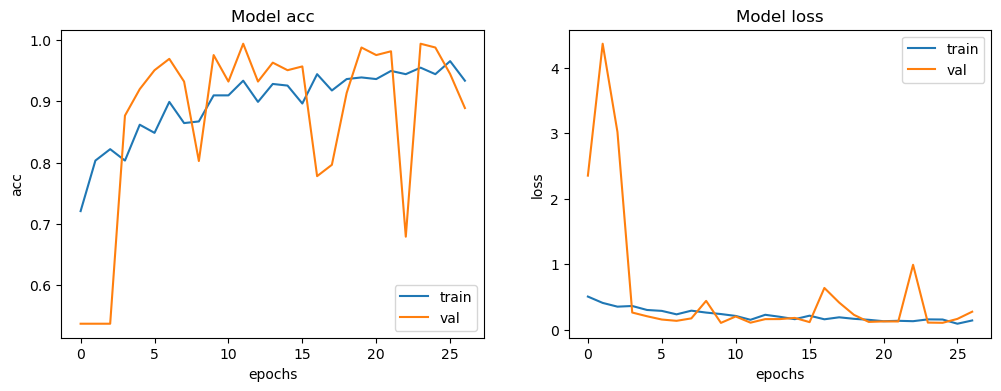

81/81 [==============================] - 2s 28ms/step - loss: 0.1065 - acc: 0.9753
Sample 29: The model predicted the MRI scan as inter, but the true class is intra.
Accuracy on test set: 98.33% (59/60 samples were correct).
tn: 39 fp: 0 fn: 1 tp: 20


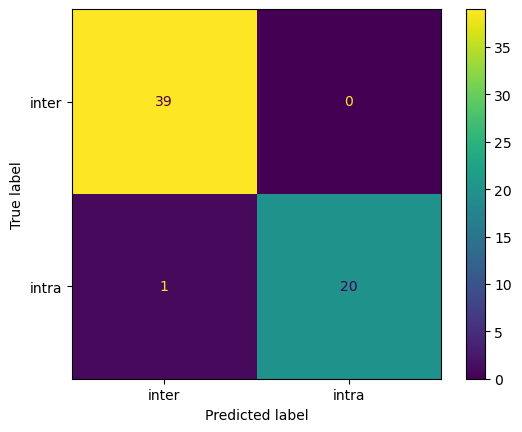

Epoch 1/100

Epoch 00001: val_loss improved from inf to 2.31397, saving model to /home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/train_ia_r_overlap_4/model_4.h5
188/188 - 31s - loss: 0.4931 - acc: 0.7340 - val_loss: 2.3140 - val_acc: 0.5062
Epoch 2/100

Epoch 00002: val_loss improved from 2.31397 to 0.91593, saving model to /home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/train_ia_r_overlap_4/model_4.h5
188/188 - 31s - loss: 0.4101 - acc: 0.7846 - val_loss: 0.9159 - val_acc: 0.5062
Epoch 3/100

Epoch 00003: val_loss did not improve from 0.91593
188/188 - 31s - loss: 0.3806 - acc: 0.8059 - val_loss: 1.3016 - val_acc: 0.5062
Epoch 4/100

Epoch 00004: val_loss improved from 0.91593 to 0.80495, saving model to /home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/train_ia_r_overlap_4/model_4.h5
188/188 - 31s - loss: 0.3018 - acc: 0.8511 - val_loss: 0.8050 - val_acc: 0.6111
Epoch 5/100

Epoch 00005: val_loss 

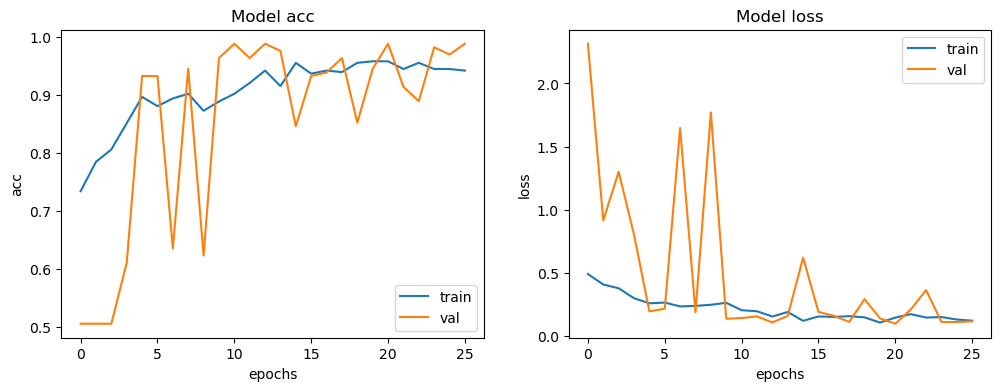

81/81 [==============================] - 2s 28ms/step - loss: 0.1001 - acc: 0.9877
Accuracy on test set: 100.00% (60/60 samples were correct).
tn: 26 fp: 0 fn: 0 tp: 34


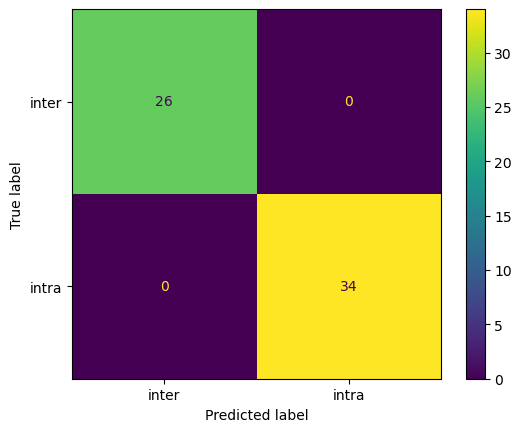

Epoch 1/100

Epoch 00001: val_loss improved from inf to 1.33840, saving model to /home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/train_ia_r_overlap_5/model_5.h5
188/188 - 31s - loss: 0.5307 - acc: 0.7287 - val_loss: 1.3384 - val_acc: 0.5556
Epoch 2/100

Epoch 00002: val_loss improved from 1.33840 to 1.11871, saving model to /home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/train_ia_r_overlap_5/model_5.h5
188/188 - 31s - loss: 0.4137 - acc: 0.7766 - val_loss: 1.1187 - val_acc: 0.5556
Epoch 3/100

Epoch 00003: val_loss did not improve from 1.11871
188/188 - 31s - loss: 0.4080 - acc: 0.7686 - val_loss: 1.3005 - val_acc: 0.4506
Epoch 4/100

Epoch 00004: val_loss improved from 1.11871 to 0.69443, saving model to /home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/train_ia_r_overlap_5/model_5.h5
188/188 - 31s - loss: 0.3889 - acc: 0.7899 - val_loss: 0.6944 - val_acc: 0.6173
Epoch 5/100

Epoch 00005: val_loss 

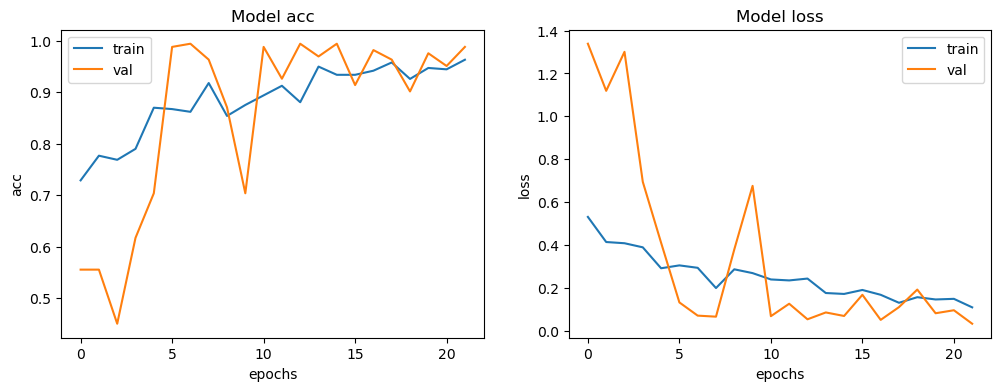

81/81 [==============================] - 2s 28ms/step - loss: 0.0327 - acc: 0.9877
Sample 8: The model predicted the MRI scan as inter, but the true class is intra.
Sample 43: The model predicted the MRI scan as inter, but the true class is intra.
Accuracy on test set: 96.67% (58/60 samples were correct).
tn: 30 fp: 0 fn: 2 tp: 28


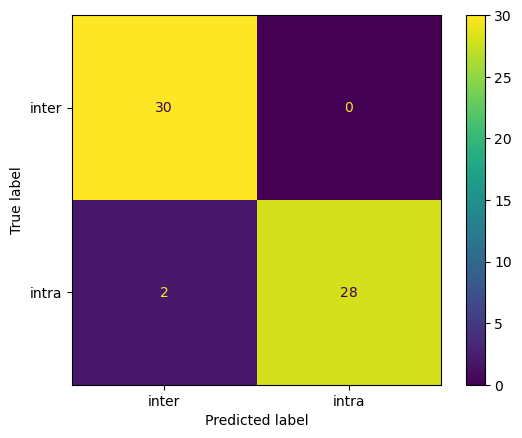

Epoch 1/100

Epoch 00001: val_loss improved from inf to 1.43751, saving model to /home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/train_ia_r_overlap_6/model_6.h5
188/188 - 32s - loss: 0.5371 - acc: 0.7074 - val_loss: 1.4375 - val_acc: 0.5741
Epoch 2/100

Epoch 00002: val_loss did not improve from 1.43751
188/188 - 31s - loss: 0.4060 - acc: 0.7979 - val_loss: 2.2202 - val_acc: 0.5741
Epoch 3/100

Epoch 00003: val_loss improved from 1.43751 to 0.28754, saving model to /home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/train_ia_r_overlap_6/model_6.h5
188/188 - 31s - loss: 0.3551 - acc: 0.8085 - val_loss: 0.2875 - val_acc: 0.9012
Epoch 4/100

Epoch 00004: val_loss did not improve from 0.28754
188/188 - 31s - loss: 0.3604 - acc: 0.8218 - val_loss: 0.6590 - val_acc: 0.6543
Epoch 5/100

Epoch 00005: val_loss improved from 0.28754 to 0.10034, saving model to /home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/tra

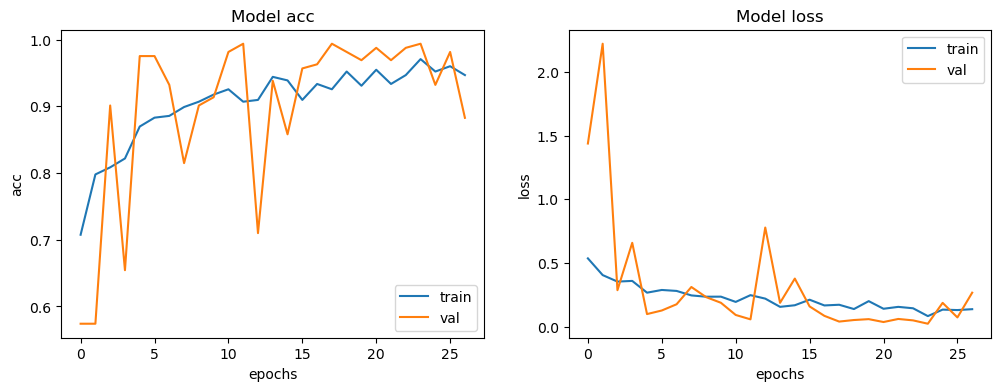

81/81 [==============================] - 2s 28ms/step - loss: 0.0247 - acc: 0.9938
Accuracy on test set: 100.00% (60/60 samples were correct).
tn: 25 fp: 0 fn: 0 tp: 35


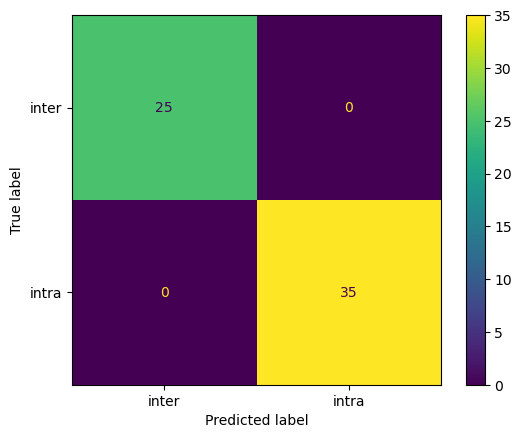

Epoch 1/100

Epoch 00001: val_loss improved from inf to 3.16479, saving model to /home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/train_ia_r_overlap_7/model_7.h5
188/188 - 31s - loss: 0.4548 - acc: 0.7713 - val_loss: 3.1648 - val_acc: 0.5062
Epoch 2/100

Epoch 00002: val_loss did not improve from 3.16479
188/188 - 31s - loss: 0.3975 - acc: 0.7660 - val_loss: 5.1290 - val_acc: 0.5062
Epoch 3/100

Epoch 00003: val_loss improved from 3.16479 to 2.63801, saving model to /home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/train_ia_r_overlap_7/model_7.h5
188/188 - 31s - loss: 0.3131 - acc: 0.8351 - val_loss: 2.6380 - val_acc: 0.5062
Epoch 4/100

Epoch 00004: val_loss improved from 2.63801 to 0.49982, saving model to /home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/train_ia_r_overlap_7/model_7.h5
188/188 - 31s - loss: 0.3167 - acc: 0.8378 - val_loss: 0.4998 - val_acc: 0.7284
Epoch 5/100

Epoch 00005: val_loss 

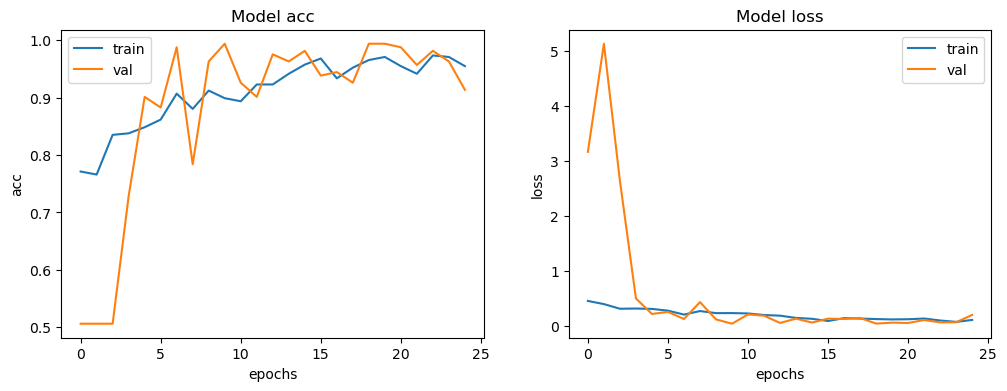

81/81 [==============================] - 2s 28ms/step - loss: 0.0408 - acc: 0.9938
Sample 2: The model predicted the MRI scan as inter, but the true class is intra.
Sample 34: The model predicted the MRI scan as inter, but the true class is intra.
Accuracy on test set: 96.67% (58/60 samples were correct).
tn: 24 fp: 0 fn: 2 tp: 34


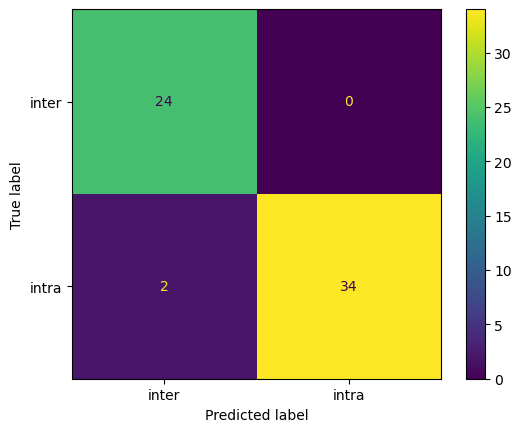

Epoch 1/100

Epoch 00001: val_loss improved from inf to 2.42565, saving model to /home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/train_ia_r_overlap_8/model_8.h5
189/189 - 32s - loss: 0.5445 - acc: 0.6817 - val_loss: 2.4257 - val_acc: 0.4506
Epoch 2/100

Epoch 00002: val_loss did not improve from 2.42565
189/189 - 31s - loss: 0.3931 - acc: 0.7958 - val_loss: 5.4595 - val_acc: 0.4506
Epoch 3/100

Epoch 00003: val_loss improved from 2.42565 to 1.55349, saving model to /home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/train_ia_r_overlap_8/model_8.h5
189/189 - 32s - loss: 0.3465 - acc: 0.8117 - val_loss: 1.5535 - val_acc: 0.4630
Epoch 4/100

Epoch 00004: val_loss improved from 1.55349 to 0.08771, saving model to /home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/train_ia_r_overlap_8/model_8.h5
189/189 - 31s - loss: 0.3887 - acc: 0.7905 - val_loss: 0.0877 - val_acc: 0.9815
Epoch 5/100

Epoch 00005: val_loss 

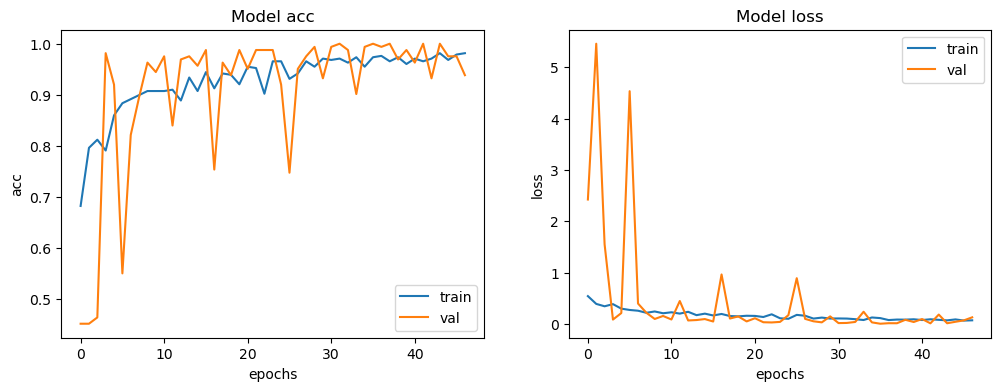

81/81 [==============================] - 2s 28ms/step - loss: 0.0071 - acc: 1.0000
Sample 14: The model predicted the MRI scan as inter, but the true class is intra.
Accuracy on test set: 98.31% (58/59 samples were correct).
tn: 38 fp: 0 fn: 1 tp: 20


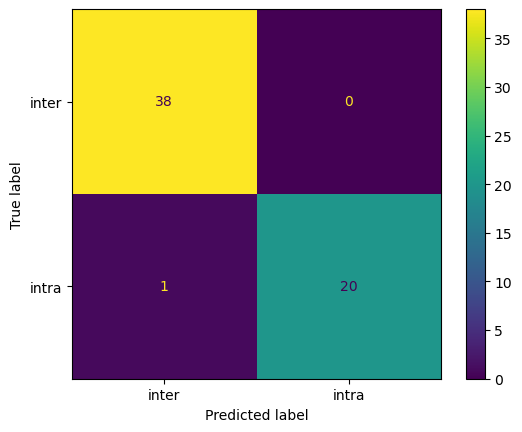

Epoch 1/100

Epoch 00001: val_loss improved from inf to 1.18497, saving model to /home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/train_ia_r_overlap_9/model_9.h5
189/189 - 31s - loss: 0.5136 - acc: 0.7321 - val_loss: 1.1850 - val_acc: 0.4691
Epoch 2/100

Epoch 00002: val_loss improved from 1.18497 to 0.73548, saving model to /home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/train_ia_r_overlap_9/model_9.h5
189/189 - 31s - loss: 0.3748 - acc: 0.8064 - val_loss: 0.7355 - val_acc: 0.5802
Epoch 3/100

Epoch 00003: val_loss improved from 0.73548 to 0.39122, saving model to /home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/train_ia_r_overlap_9/model_9.h5
189/189 - 31s - loss: 0.3230 - acc: 0.8541 - val_loss: 0.3912 - val_acc: 0.8704
Epoch 4/100

Epoch 00004: val_loss did not improve from 0.39122
189/189 - 31s - loss: 0.3518 - acc: 0.8276 - val_loss: 0.6776 - val_acc: 0.6111
Epoch 5/100

Epoch 00005: val_loss 

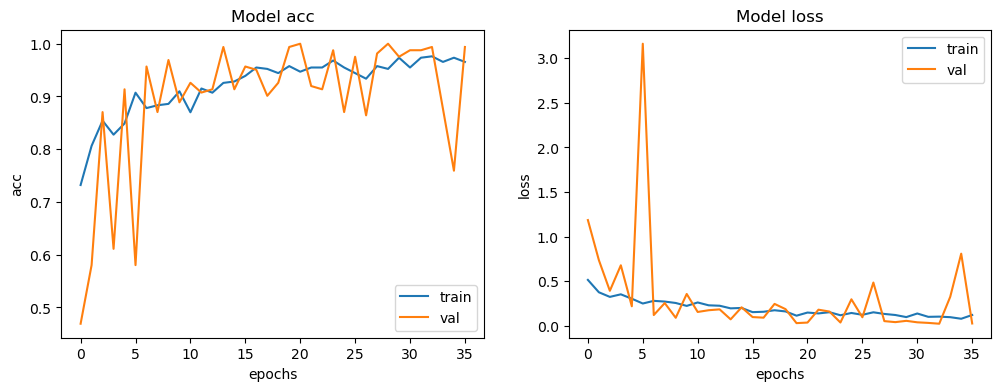

81/81 [==============================] - 2s 31ms/step - loss: 0.0219 - acc: 0.9938
Sample 30: The model predicted the MRI scan as inter, but the true class is intra.
Accuracy on test set: 98.31% (58/59 samples were correct).
tn: 23 fp: 0 fn: 1 tp: 35


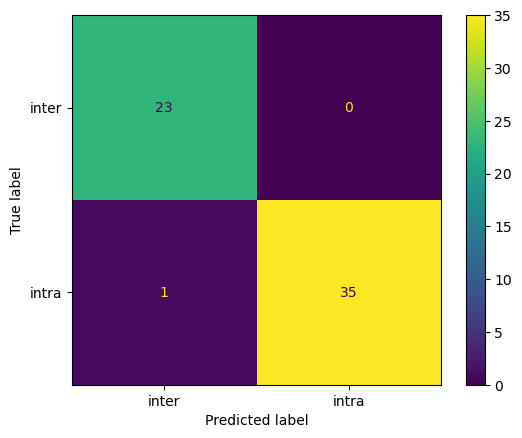

validation accuracy [0.9876543283462524, 0.9938271641731262, 0.9938271641731262, 0.9753086566925049, 0.9876543283462524, 0.9876543283462524, 0.9938271641731262, 0.9938271641731262, 1.0, 0.9938271641731262]
test accuracy [1.0, 1.0, 0.9666666666666667, 0.9833333333333333, 1.0, 0.9666666666666667, 1.0, 0.9666666666666667, 0.9830508474576272, 0.9830508474576272]
test f1_score [1.0, 1.0, 0.9666666666666666, 0.975609756097561, 1.0, 0.9655172413793104, 1.0, 0.9714285714285714, 0.975609756097561, 0.9859154929577464]
mean validation accuracy 0.9907407462596893 0.006325274480432712
mean test accuracy 0.9849435028248589 0.01385163377753685
mean f1 score 0.9840747484627416 0.01403033589202639


In [113]:
from sklearn.model_selection import KFold, train_test_split
VALIDATION_ACCURACY = []
VALIDATION_LOSS = []
TEST_ACCURACY = []
TEST_F1_SCORE = []


fold_var = 0
kf = KFold(n_splits=10, shuffle=True, random_state=random_state)
        
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
				initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
			)
for train_index, test_index in kf.split(train_data):
    train_iteration = f'_overlap_{fold_var}'
    train_dir = os.path.join(os.getcwd(), f'train_{experiment_name}{train_iteration}')
    # Create both train_dir if not already existent
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    # Further split the training data into 70% training and 30% validation
    new_train_index, val_index = train_test_split(train_index, test_size=0.3, random_state=random_state)
    
    x_train, y_train = train_data[new_train_index], y_data[new_train_index]
    x_val, y_val = train_data[val_index], y_data[val_index]
    x_test, y_test = train_data[test_index], y_data[test_index]      
    # Obtain augmented data for train set
    train_dataset, validation_dataset = data_loaders(x_train, y_train, x_val, y_val, batch_size=2)
	# Create new model
    model = get_model(width=128, height=128, depth=64)
	# Compile model
    model.compile(
		loss="binary_crossentropy",
		optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
		metrics=["acc"],
	)
    # CREATE CALLBACKS
    early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

    checkpoint = tf.keras.callbacks.ModelCheckpoint(f'{train_dir}/{get_model_name(fold_var)}', 
							monitor='val_loss', verbose=1, 
							save_best_only=True, mode='min')
    callbacks_list = [checkpoint, early_stopping_cb]
	# There can be other callbacks, but just showing one because it involves the model name
	# This saves the best model
	# FIT THE MODEL
    epochs = 100
    history = model.fit(train_dataset,
			    epochs=epochs,
			    callbacks=callbacks_list,
                shuffle=True,
		        verbose=2,
			    validation_data=validation_dataset)
    
    visualize_model_performance(model, train_dir)
    # LOAD BEST MODEL to evaluate the performance of the model
    model.load_weights(f'{train_dir}/{get_model_name(fold_var)}')
	
    results = model.evaluate(validation_dataset)
    results = dict(zip(model.metrics_names,results))

    accuracy, f1_score_calc = calculate_accuracy_test_set(model, x_test, y_test, train_dir)
	
    VALIDATION_ACCURACY.append(results['acc'])
    VALIDATION_LOSS.append(results['loss'])
    TEST_ACCURACY.append(accuracy)
    TEST_F1_SCORE.append(f1_score_calc)
    tf.keras.backend.clear_session()
    fold_var += 1

print('validation accuracy', VALIDATION_ACCURACY)
print('test accuracy', TEST_ACCURACY)
print('test f1_score', TEST_F1_SCORE)
print('mean validation accuracy', np.mean(VALIDATION_ACCURACY), np.std(VALIDATION_ACCURACY))
print('mean test accuracy', np.mean(TEST_ACCURACY), np.std(TEST_ACCURACY))
print('mean f1 score', np.mean(TEST_F1_SCORE), np.std(TEST_F1_SCORE))


It is important to note that the number of samples is very small (only 200) and we don't
specify a random seed. As such, you can expect significant variance in the results. The full dataset
which consists of over 1000 CT scans can be found [here](https://www.medrxiv.org/content/10.1101/2020.05.20.20100362v1). Using the full
dataset, an accuracy of 83% was achieved. A variability of 6-7% in the classification
performance is observed in both cases.

## Visualizing the model

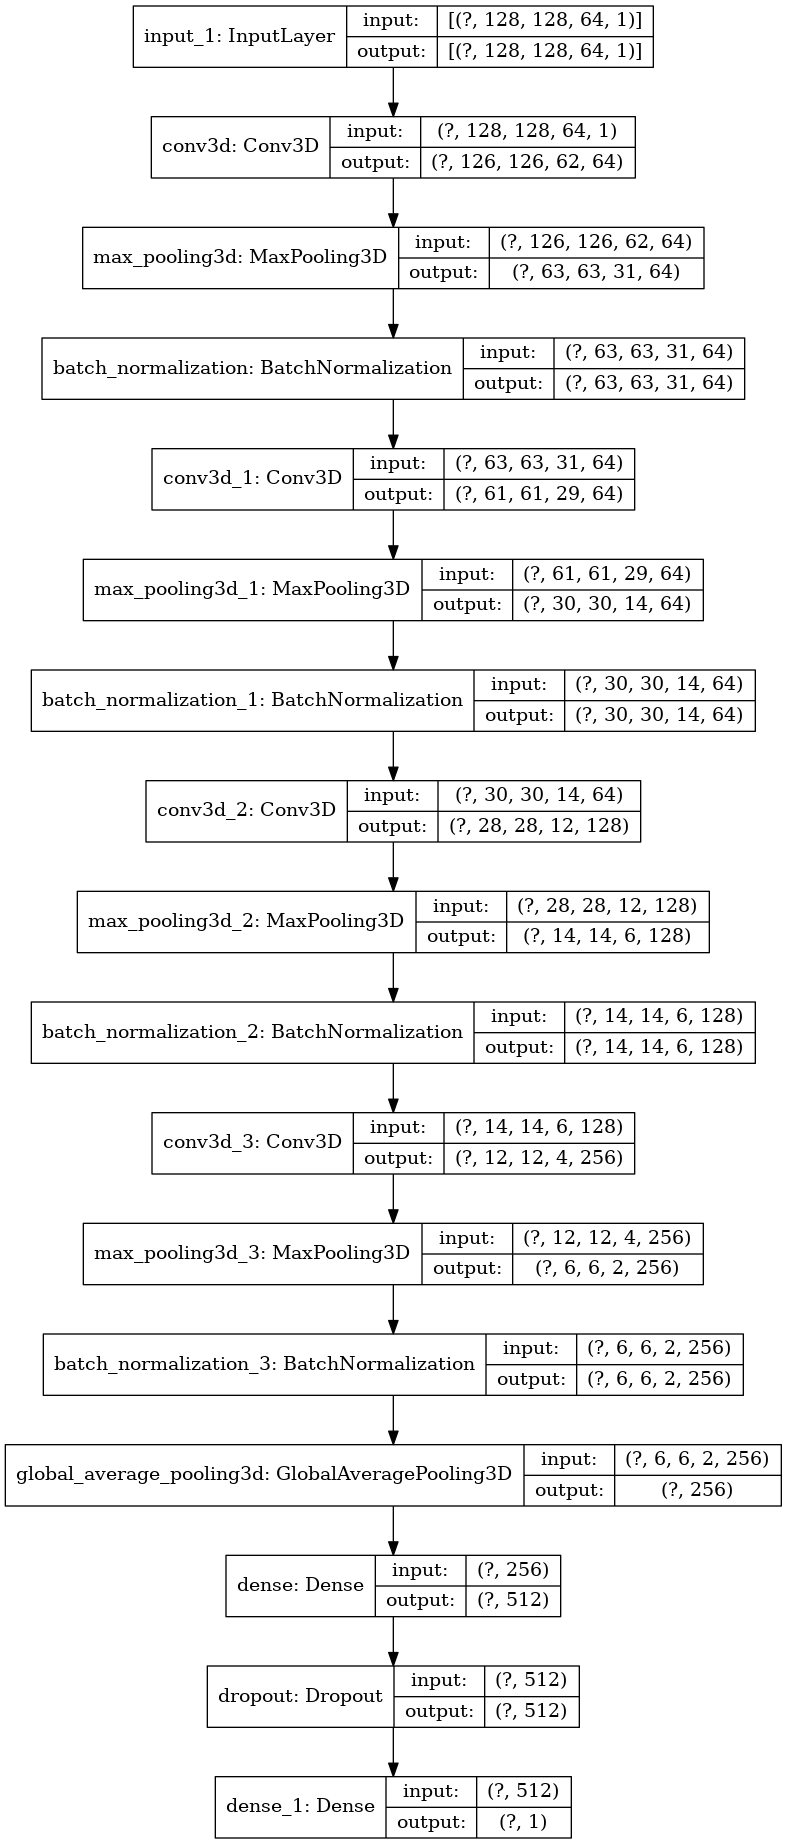

In [39]:
from tensorflow.keras.utils import plot_model
# Save the model architecture as an image file
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

## Visualizing model performance

Here the model accuracy and loss for the training and the validation sets are plotted.
Since the validation set is class-balanced, accuracy provides an unbiased representation
of the model's performance.

In [ ]:
visualize_model_performance(model, log_dir)

## Make predictions on a single MRI scan

In [30]:
print('x_val shape', x_val.shape)
img_number = 40
img_to_predict = x_val[img_number]
# 1 is for intra and 0 is for inter
y_val_to_be_predicted = y_val[img_number]
epoch = '11'
model.load_weights(f"{train_dir}/3d_image_classification_epoch{epoch}.h5")
prediction = model.predict(np.expand_dims(img_to_predict, axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

class_names = ["inter", "intra"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that MRI scan is %s"
        % ((100 * score), name)
    )

x_val shape (59, 128, 128, 64)
This model is 89.62 percent confident that MRI scan is inter
This model is 10.38 percent confident that MRI scan is intra


## Calculate accuracy on validation set

In [31]:
class_names = ["inter", "intra"]
correct_predictions = 0

for sample_index in range(x_val.shape[0]):
    img_to_predict = x_val[sample_index].reshape(1, *x_val[sample_index].shape)
    true_class = y_val[sample_index]

    prediction = model.predict(img_to_predict)[0]
    predicted_class = 1 if prediction[0] >= 0.5 else 0  # Assuming a threshold of 0.5

    predicted_class_name = class_names[predicted_class]
    true_class_name = class_names[true_class]

    if predicted_class == true_class:
        # print(f"Sample {sample_index}: The model correctly predicted the MRI scan as {predicted_class_name}.")
        correct_predictions += 1
    else:
        print(f"Sample {sample_index}: The model predicted the MRI scan as {predicted_class_name}, but the true class is {true_class_name}.")

accuracy_percentage = (correct_predictions / x_val.shape[0]) * 100
print(f"Accuracy on validation set: {accuracy_percentage:.2f}% ({correct_predictions}/{x_val.shape[0]} samples were correct).")


Sample 2: The model predicted the MRI scan as inter, but the true class is intra.
Sample 14: The model predicted the MRI scan as inter, but the true class is intra.
Sample 20: The model predicted the MRI scan as inter, but the true class is intra.
Accuracy on validation set: 94.92% (56/59 samples were correct).


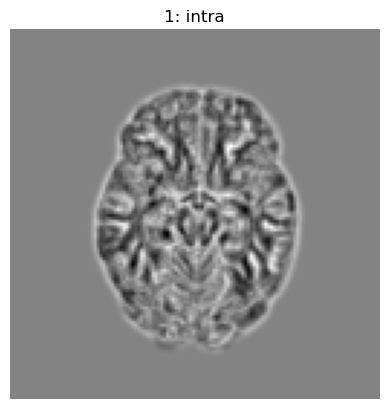

In [26]:
i = 13
image = x_val[i, :, :, :]
label = y_val[i]
plt.imshow(np.squeeze(image[:, :, 32]), cmap='gray')
if label == 1:
    plt.title("1: intra")
elif label == 0:
    plt.title("0: inter")
plt.axis('off')
plt.show()

### Calculate AUC (Area under curve) on test set

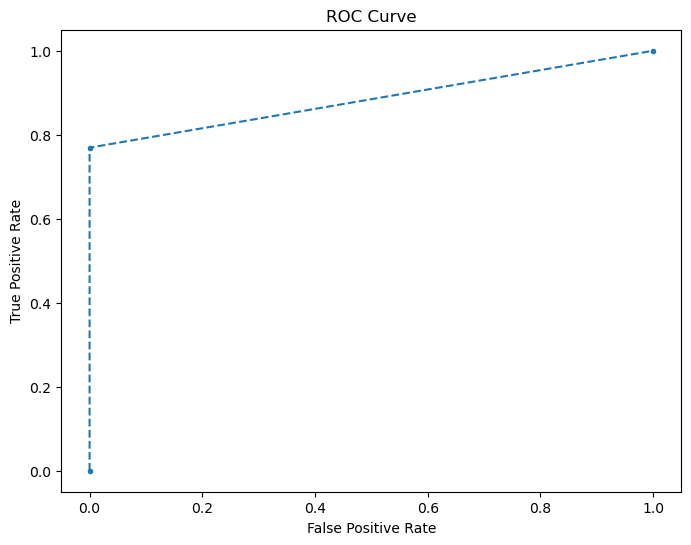

In [34]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# y_true contains the true binary labels (0 or 1)
# y_pred contains the predicted probabilities for the positive class
auc = roc_auc_score(y_test, y_pred)

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linestyle='--', marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

### Unsupervised VAE to cluster intra-inter scans

In [5]:
import random

from scipy import ndimage


@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < -1] = -1
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume


def validation_preprocessing(volume):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume

In [6]:
def data_loaders_vae(x_train, x_val, batch_size):
    # Define data loaders.
    train_loader = tf.data.Dataset.from_tensor_slices(x_train)
    validation_loader = tf.data.Dataset.from_tensor_slices(x_val)

    # Augment the data on the fly during training.
    train_dataset = (
        train_loader.shuffle(len(x_train))
        .map(train_preprocessing)
        .batch(batch_size)
        .prefetch(2)
    )
    # Only rescale.
    validation_dataset = (
        validation_loader.shuffle(len(x_val))
        .map(validation_preprocessing)
        .batch(batch_size)
        .prefetch(2)
    )
    return train_dataset, validation_dataset

#### Sampling Layer

In [7]:
class Sampling(layers.Layer):
    #REPARAMETRIZATION TRICK Z=MU+SIGMA*EPSILON
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a log Jacobian image."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim)) #tf.keras.backend.random_normal(shape=(batch,dim)) #only difference is this function call
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

#### Build Encoder

In [8]:
def buildEncoder(latent_dim, encoderInputs):  
    # prev, 64,32,128
    l1 = keras.models.Sequential([
        layers.Conv3D(64, 3, activation="relu", strides=2, padding="same"),
        layers.Conv3D(32, 3, activation="relu", strides=2, padding="same"),
        layers.Flatten(),
        layers.Dense(128, activation="relu")        
    ])
    
    x = l1(encoderInputs)
    
    zMean = layers.Dense(latent_dim, name="z_mean")(x)
    
    zLogVar = layers.Dense(latent_dim,name="z_log_var")(x)
    
    z =  Sampling()([zMean, zLogVar])
    
    return keras.Model(encoderInputs, [zMean, zLogVar, z], name="encoder")
latent_dim = 3
# input_shape = train_data.shape
input_shape = (128, 128, 64, 1)
# input_shape = (64, 64, 32, 1)
encoderInputs = keras.Input(shape=input_shape) #shape to be changed; 128,128,64, previous: (64, 64, 32, 1)
encoder = buildEncoder(latent_dim, encoderInputs)
encoder.summary()

2023-11-22 14:30:09.245835: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-11-22 14:30:09.248376: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-22 14:30:09.248613: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3070 computeCapability: 8.6
coreClock: 1.755GHz coreCount: 46 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2023-11-22 14:30:09.249036: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-11-22 14:30:09.249942: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-11-22 14:30:09.250891: I tensorflow/stream_executor/pla

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 64 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128)          67166112    input_1[0][0]                    
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 3)            387         sequential[0][0]                 
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 3)            387         sequential[0][0]                 
____________________________________________________________________________________________

#### Build Decoder

In [9]:
def buildDecoder(latentInputs):
    l1 = keras.models.Sequential([
        layers.Dense(32*32*16*64, activation="relu", input_shape=(latentInputs.shape[1],)),
        layers.Reshape((32,32,16,64)),
        layers.Conv3DTranspose(filters=64, kernel_size=3, activation="relu", strides=2, padding="same"),
        layers.Conv3DTranspose(filters=32, kernel_size=3, activation="relu", strides=2, padding="same"),
        layers.Conv3DTranspose(filters=1, kernel_size=3, activation="sigmoid", padding="same")     
    ])
    
    return keras.Model(latentInputs, l1(latentInputs), name="decoder")

latentInputs = keras.Input(shape=(latent_dim,))
decoder = buildDecoder(latentInputs)
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 128, 128, 64, 1)   4361153   
Total params: 4,361,153
Trainable params: 4,361,153
Non-trainable params: 0
_________________________________________________________________


#### Losses

In [12]:
def reconstructionLoss(data, reconstructed):
    return tf.reduce_mean(
        tf.reduce_sum(
            keras.losses.binary_crossentropy(data, reconstructed),
            axis=(1,2)
        )
    )

In [13]:
def klDivergenceLoss(zMean, zLogVar):
    return tf.reduce_mean(
        tf.reduce_sum(
            -0.5 * (1 + zLogVar - tf.square(zMean) - tf.exp(zLogVar)),
            axis=1
        )
    )

In [14]:
def calcTotalLoss(data, reconstructed, zMean, zLogVar):
    loss1 = reconstructionLoss(data, reconstructed)
    loss2 = klDivergenceLoss(zMean,zLogVar)
    klWeight = 3.0
    return loss1, loss2, loss1 + klWeight * loss2

#### Model

In [15]:
class VAE(keras.Model):    
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder=encoder
        self.decoder=decoder

        self.totalLossTracker= keras.metrics.Mean(name="total_loss")
        self.ceLossTracker= keras.metrics.Mean(name="ce_loss")
        self.klLossTracker= keras.metrics.Mean(name="kl_loss")
    
    @property
    def metrics(self):
        return[
            self.totalLossTracker,
            self.ceLossTracker,
            self.klLossTracker            
        ]
    
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            zMean, zLogVar, z = self.encoder(data)
            reconstruction = self.decoder(z)
            ceLoss, klLoss, totalLoss = calcTotalLoss(data,reconstruction,zMean,zLogVar)

        # Compute gradients
        grads = tape.gradient(totalLoss, self.trainable_weights)
        # Update weights
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.totalLossTracker.update_state(totalLoss)
        self.ceLossTracker.update_state(ceLoss)
        self.klLossTracker.update_state(klLoss)
        
        return{
            "total_loss": self.totalLossTracker.result(),
            "ce_loss": self.ceLossTracker.result(),
            "kl_loss": self.klLossTracker.result()   
        }
    def test_step(self, data):
        zMean, zLogVar, z = self.encoder(data)
        reconstruction = self.decoder(z)
        # Updates the metrics tracking the loss
        ceLoss, klLoss, totalLoss = calcTotalLoss(data,reconstruction,zMean,zLogVar)
        # self.compute_loss(y=y, y_pred=y_pred)
        # Update the metrics.
        self.totalLossTracker.update_state(totalLoss)
        self.ceLossTracker.update_state(ceLoss)
        self.klLossTracker.update_state(klLoss)
        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {m.name: m.result() for m in self.metrics}
    
    # implement the call method
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        return reconstructed

In [16]:
def create_vae(latent_dim, input_dim):
    # Encoder
    encoderInputs = keras.Input(shape=input_dim) #shape to be changed; 128,128,64, previous: (64, 64, 32, 1)
    encoder = buildEncoder(latent_dim, encoderInputs)
    
    # Decoder
    latentInputs = keras.Input(shape=(latent_dim,))
    decoder = buildDecoder(latentInputs)
    
    # Compile the VAE
    vae=VAE(encoder, decoder)
    vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001))
    
    return vae

#### Training

In [17]:
def plot_losses(history):
    plt.figure(figsize=(10,9))
    plt.plot(history.history.get("total_loss"), label= "total loss")
    plt.plot(history.history.get("ce_loss"), label= "reconstruction loss")
    plt.plot(history.history.get("kl_loss"), label= "kl loss")
    plt.plot(history.history.get("val_total_loss"), label= "val total loss")
    plt.plot(history.history.get("val_ce_loss"), label= "val reconstruction loss")
    plt.plot(history.history.get("val_kl_loss"), label= "val kl loss")
    plt.legend()
    plt.xlabel('Epochs')
    plt.show()

In [63]:
import os

def write_global_paths_to_txt(root_folder, output_dir, output_type="input"):
    global_output_txt = os.path.join(output_dir, f"{output_type}_paths_global.txt")
    with open(global_output_txt, 'w') as global_txt_file:
        for model_name in ['NoReg', 'RigidReg', 'RigidAffineReg']:
            for fold_number in range(5):
                folder_path = os.path.join(root_folder, f"dataset_{model_name}_1.5_f{fold_number}/test/images/")
                for foldername, _, filenames in os.walk(folder_path):
                    if output_type == "input" or "output":
                        nii_files = [filename for filename in filenames if filename.endswith('.nii.gz')]
                        if len(nii_files) == 2:
                            path1 = os.path.join(foldername, nii_files[0])
                            path2 = os.path.join(foldername, nii_files[1])
                            if output_type == "input":
                                global_txt_file.write(f"{path1}\n{path2}\n")
                            else:
                                path1_to_write = path1.replace('/images/', '/labels/')
                                path2_to_write = path2.replace('/images/', '/labels/')
                                global_txt_file.write(f"{path1_to_write}\n{path2_to_write}\n")
                    # elif output_type == "output":
                    #     folder_to_write = foldername.replace('/images/', '/labels/')
                    #     if folder_to_write.endswith('labels/'):
                    #         print(fold_number)
                    #     else:
                    #         global_txt_file.write(f"{folder_to_write}/\n")  # Write subfolder path
                    #         global_txt_file.write(f"{folder_to_write}/\n")  # Write subfolder path
                    else:
                        folder_to_write = foldername.replace('/images/', '/labels/')
                        if folder_to_write.endswith('labels/'):
                            print(fold_number)
                        else:
                            global_txt_file.write(f"{folder_to_write}/qc1.csv\n")
                            global_txt_file.write(f"{folder_to_write}/qc2.csv\n")  

                            

# Example usage for input and output paths:
root_folder = "/media/andjela/SeagatePor/"
output_dir = "/media/andjela/SeagatePor/input_paths/"
# write_global_paths_to_txt(root_folder, output_dir, output_type="input")
write_global_paths_to_txt(root_folder, output_dir, output_type="output")
# write_global_paths_to_txt(root_folder, output_dir, output_type="qc")


In [82]:
def plot_all_losses(all_train_loss_histories, all_val_loss_histories, latent_dimensions):
    fig, ax = plt.subplots(2, 2, figsize=(12, 10))

    for (metric_train, train_loss), (metric_val, val_loss) in zip(all_train_loss_histories.items(), all_val_loss_histories.items()):
        for i in range(len(latent_dimensions)):

            # Determine the subplot index based on the value of i
            if i == 0:
                subplot_index = (0, 0)
            elif i == 1:
                subplot_index = (0, 1)
            elif i == 2:
                subplot_index = (1, 0)
            elif i == 3:
                subplot_index = (1, 1)
            else:
                raise ValueError(f"Invalid value of i: {i}")

            # Plot on the specified subplot
            ax[subplot_index].plot(train_loss[i], label=f"train_{metric_train}")
            ax[subplot_index].plot(val_loss[i], label=f"{metric_val}")

    # Add legends, labels, and show the plot
    i = 0
    for subplot_row in ax:
        for subplot in subplot_row:
            subplot.legend()
            subplot.grid(True)
            subplot.set_title(f'Latent dimensions: {latent_dimensions[i]}')
            subplot.set_xlabel('Epochs')
            i += 1

    plt.show()

# Example usage:
# Assuming you have dictionaries all_train_loss_histories, all_val_loss_histories, and a list latent_dimensions
# plot_all_losses(all_train_loss_histories, all_val_loss_histories, latent_dimensions)


In [16]:
import matplotlib as mpl
def visualize_test_reconstructions(best_model, x_test, save_path, best_model_index):
    _ ,_ , z = best_model.encoder.predict(x_test)

    synth = best_model.decoder.predict([z])
    print('SYNTH SHAPE', synth.shape)

    # z = np.random.normal(loc=0, scale=4, size=(256,3))
    # synth= vae.decoder.predict(z)
    plt.figure(figsize=(12,28))
    for i in range(28):
        plt.subplot(4, 7, i+1)
        new_t=synth[i].reshape(128,128,64)
        plt.imshow(new_t[:,:,32], cmap=mpl.cm.gray) 
    plt.savefig(f'{save_path}/recon_model_{best_model_index}.png')

In [22]:
tf.keras.backend.clear_session()

In [85]:
from sklearn.model_selection import KFold, train_test_split
import os

# num_epochs = 100
num_epochs = 300
batch_size = 2
# latent_dimensions = [3, 16, 64, 128]
latent_dimensions = [2, 3, 16, 32]
input_dim = (128, 128, 64, 1)

validation_losses = []
# Create a dictionary to store training and validation loss histories for all models
all_train_loss_histories = {metric: [] for metric in ["total_loss", "kl_loss", "ce_loss"]}
all_val_loss_histories = {metric: [] for metric in ["val_total_loss", "val_kl_loss", "val_ce_loss"]}


kf = KFold(n_splits=10, shuffle=True, random_state=random_state)
fold_var = 0

for train_index, test_index in kf.split(train_data):
    train_iteration = f'_vae_overlap_{fold_var}'
    train_dir = os.path.join(os.getcwd(), f'train{train_iteration}')
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    
    # Further split the training data into 70% training and 30% validation
    new_train_index, val_index = train_test_split(train_index, test_size=0.3, random_state=random_state)
    
    x_train = train_data[new_train_index]
    x_val = train_data[val_index]
    x_test = train_data[test_index]      
    # Obtain augmented data for train set
    train_dataset, validation_dataset = data_loaders_vae(x_train, x_val, batch_size=batch_size)

    # Create and compile different VAE models with various latent dimensions
    models = [create_vae(latent_dim, input_dim) for latent_dim in latent_dimensions]

    # Train each model on the training data, evaluate using the validation set, and select the best-performing model
    # Train each model on the training data
    for i, model in enumerate(models):
        # Callbacks for model checkpoint and early stopping
        checkpoint = tf.keras.callbacks.ModelCheckpoint(
            f'{train_dir}/model_latent_{latent_dimensions[i]}_{fold_var}.h5',
            monitor='val_total_loss',
            verbose=1,
            save_best_only=True,
            mode='min'
        )
        early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_total_loss", patience=15)
        callbacks_list = [checkpoint, early_stopping_cb]
        # Model training
        history = model.fit(train_dataset, validation_data=validation_dataset, epochs=num_epochs, batch_size=batch_size, callbacks=callbacks_list, verbose=2)
        # plot_losses(history)
        # Append training and validation loss histories to the list for each metric
        for metric in all_train_loss_histories:
            all_train_loss_histories[metric].append(history.history.get(metric))
        for metric in all_val_loss_histories:
            all_val_loss_histories[metric].append(history.history.get(metric))


        # Evaluate models on the validation set
        print(f'LATENT DIMENSION:, {latent_dimensions[i]}')
        results = model.evaluate(validation_dataset)
        results = dict(zip(model.metrics_names,results))
        validation_losses.append(results['total_loss'])
    
    # Call the plot_losses function to create the plot
    plot_all_losses(all_train_loss_histories, all_val_loss_histories, latent_dimensions)
    # Find the best-performing model based on the lowest validation loss
    best_model_index = validation_losses.index(min(validation_losses))
    best_model = models[best_model_index]
    # Now, evaluate the best model on the test set
    test_loss = best_model.evaluate(x_test)
    print(f'Best model loss on test set for fold {fold_var}: {test_loss}')
    visualize_test_reconstructions(best_model, x_test, train_dir, best_model_index)
    tf.keras.backend.clear_session()
    fold_var += 1  # Move to the next fold


Epoch 1/300


2023-11-22 11:34:24.529272: W tensorflow/core/common_runtime/bfc_allocator.cc:434] Allocator (GPU_0_bfc) ran out of memory trying to allocate 256.00MiB (rounded to 268435456)
Current allocation summary follows.
2023-11-22 11:34:24.529304: I tensorflow/core/common_runtime/bfc_allocator.cc:934] BFCAllocator dump for GPU_0_bfc
2023-11-22 11:34:24.529310: I tensorflow/core/common_runtime/bfc_allocator.cc:941] Bin (256): 	Total Chunks: 319, Chunks in use: 318. 79.8KiB allocated for chunks. 79.5KiB in use in bin. 16.9KiB client-requested in use in bin.
2023-11-22 11:34:24.529314: I tensorflow/core/common_runtime/bfc_allocator.cc:941] Bin (512): 	Total Chunks: 20, Chunks in use: 19. 10.0KiB allocated for chunks. 9.5KiB in use in bin. 9.5KiB client-requested in use in bin.
2023-11-22 11:34:24.529318: I tensorflow/core/common_runtime/bfc_allocator.cc:941] Bin (1024): 	Total Chunks: 23, Chunks in use: 23. 28.5KiB allocated for chunks. 28.5KiB in use in bin. 27.5KiB client-requested in use in bin

ResourceExhaustedError:  OOM when allocating tensor with shape[2,128,128,64,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node decoder/sequential_11/conv3d_transpose_16/conv3d_transpose (defined at tmp/ipykernel_4907/665148852.py:23) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_417727]

Function call stack:
train_function


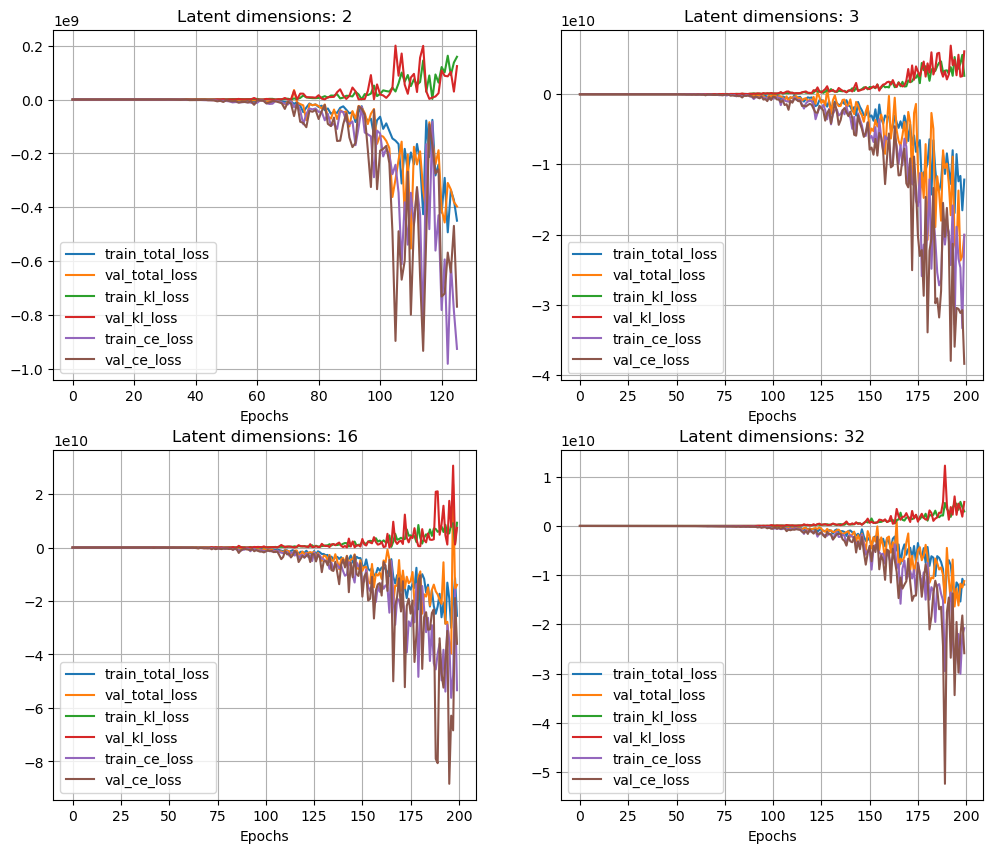

In [83]:
import ast

# Define the file path
file_path_train = '/home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/all_train_losses'
file_path_val = '/home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/all_val_losses'

latent_dimensions = [2, 3, 16, 32]

# Read the content of the file
with open(file_path_train, 'r') as file:
    content_train = file.read()

# Read the content of the file
with open(file_path_val, 'r') as file:
    content_val = file.read()

# Convert the string representation of dictionary to an actual dictionary
data_train = ast.literal_eval(content_train)
data_val = ast.literal_eval(content_val)

plot_all_losses(data_train, data_val, latent_dimensions)


In [ ]:
from sklearn.model_selection import KFold, train_test_split
VALIDATION_ACCURACY = []
VALIDATION_LOSS = []
TEST_ACCURACY = []
TEST_F1_SCORE = []


fold_var = 0
kf = KFold(n_splits=10, shuffle=True, random_state=random_state)
        
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
				initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
			)
for train_index, test_index in kf.split(train_data):
    train_iteration = f'_overlap_{fold_var}'
    train_dir = os.path.join(os.getcwd(), f'train{train_iteration}')
    # Create both train_dir if not already existent
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    # Further split the training data into 70% training and 30% validation
    new_train_index, val_index = train_test_split(train_index, test_size=0.3, random_state=random_state)
    
    x_train, y_train = train_data[new_train_index], y_data[new_train_index]
    x_val, y_val = train_data[val_index], y_data[val_index]
    x_test, y_test = train_data[test_index], y_data[test_index]      
    # Obtain augmented data for train set
    train_dataset, validation_dataset = data_loaders(x_train, y_train, x_val, y_val, batch_size=2)
	# Create new model
    model = get_model(width=128, height=128, depth=64)
	# Compile model
    model.compile(
		loss="binary_crossentropy",
		optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
		metrics=["acc"],
	)
    # CREATE CALLBACKS
    early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

    checkpoint = tf.keras.callbacks.ModelCheckpoint(f'{train_dir}/{get_model_name(fold_var)}', 
							monitor='val_loss', verbose=1, 
							save_best_only=True, mode='min')
    callbacks_list = [checkpoint, early_stopping_cb]
	# There can be other callbacks, but just showing one because it involves the model name
	# This saves the best model
	# FIT THE MODEL
    epochs = 100
    history = model.fit(train_dataset,
			    epochs=epochs,
			    callbacks=callbacks_list,
                shuffle=True,
		        verbose=2,
			    validation_data=validation_dataset)
    
    visualize_model_performance(model, train_dir)
    # LOAD BEST MODEL to evaluate the performance of the model
    model.load_weights(f'{train_dir}/{get_model_name(fold_var)}')
	
    results = model.evaluate(validation_dataset)
    results = dict(zip(model.metrics_names,results))

    accuracy, f1_score_calc = calculate_accuracy_test_set(model, x_test, y_test, train_dir)
	
    VALIDATION_ACCURACY.append(results['acc'])
    VALIDATION_LOSS.append(results['loss'])
    TEST_ACCURACY.append(accuracy)
    TEST_F1_SCORE.append(f1_score_calc)
    tf.keras.backend.clear_session()
    fold_var += 1


#### Evaluate on test set

In [ ]:
# Evaluate the best model on the test set
test_loss = best_model.evaluate(x_test, x_test)
print("Test loss with best-performing model:", test_loss)

#### Visualizing the training

In [ ]:
plt.figure(figsize=(10,9))
plt.plot(history.history.get("kl_loss"), label= "kl loss")
plt.legend()

#### Reconstructing from new samples

In [ ]:
import matplotlib as mpl
synth= vae.decoder.predict([[1, 2, 2]])
new_tumor=synth.reshape((64,64,32))
plt.imshow(new_tumor[:,:,10], cmap=mpl.cm.gray)

In [ ]:
z = np.random.normal(loc=0, scale=4, size=(256,3))
synth= vae.decoder.predict(z)
plt.figure(figsize=(28,28))
for i in range(256):
    plt.subplot(16, 16, i+1)
    new_t=synth[i].reshape(64,64,32)
    plt.imshow(new_t[:,:,10], cmap=mpl.cm.gray)  
    

plt.show()

In [ ]:
idx= 20
batch = np.expand_dims(x_train[idx], axis=0)
batchOfImages= np.expand_dims(batch, axis=-1).astype("float32")/255
print(batchOfImages.shape)

_ ,_ , z = vae.encoder.predict(batchOfImages)

synth = vae.decoder.predict([z])

z

In [ ]:
plt.figure(figsize=(28,28))
 # ORIGINAL
plt.subplot(1,2,1)
plt.axis('off')
tumor_o=x_train[idx]
plt.imshow(tumor_o[:,:,10], cmap=mpl.cm.gray)  
plt.show()

# RECONSTRUCTED

plt.subplot(1,2,2)
plt.axis('off')
new_t=synth[0].reshape(64,64,32)
plt.imshow(new_t[:,:,10], cmap=mpl.cm.gray)

#### Display latent space clustering

In [ ]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)

In [ ]:
labels= np.concatenate([y_train, y_test], axis=0)
menu, _, _= vae.encoder.predict(dataset)
plt.figure(figsize=(12,10))
plt.scatter(menu[:,0], menu[:,1], c=labels)
plt.colorbar()
plt.xlabel("menu[0]")
plt.ylabel("menu[1]")
plt.zlabel("menu[2]")
plt.show()